# Group Session Feedback Analysis - Impact and Insights for Future Development
* Descriptive statistics and topic analysis (via Latent Dirichlet Allocation, or LDA) of group session feedback survey responses across facilitators
    * Surveys are **not** uniform across facilitators
    * Standardized group session surveys for all facilitators will be rolled out in **April 2024**

### Modules

In [1]:
# General
import pandas as pd
import math
import random
import numpy as np
import statistics as stat
from scipy import stats

import re
import copy
import pickle
import textwrap
import datetime
import itertools
from pprint import pprint
from collections import defaultdict
from collections import Counter

import os
import sys
import glob

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as col
from matplotlib import colormaps as colmap
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
from wordcloud import WordCloud

sns.set()
%matplotlib inline

# Pandas display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.precision', 4)

In [2]:
# NLP
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel
from gensim.models import CoherenceModel
from gensim.test.utils import datapath

import spacy

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk import tokenize
nltk.download('punkt')

import tomotopy as tp
from plotnine import *

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arthurpelullo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/arthurpelullo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Cobalt Reporting System
sys.path.append('./reporting_system')
from cobalt_reporting_functions import *

# Program Parameters

## Constants

### Paths 
* All existing cobalt paths are accessible

In [4]:
FB_DATA_PATH = GROUP_SESSION_FEEDBACK_DATA_PATH
FB_LOGS_PATH = GROUP_SESSION_FEEDBACK_LOGS_PATH
FB_MODELS_PATH = GROUP_SESSION_FEEDBACK_MODELS_PATH
FB_OUTPUT_PATH = GROUP_SESSION_FEEDBACK_OUTPUT_PATH

FB_MASTER_DATA_PATH = GROUP_SESSION_FEEDBACK_MASTER_DATA_PATH
FB_SESSIONS_DATA_PATH = GROUP_SESSION_FEEDBACK_SESSIONS_DATA_PATH
FB_SESSIONS_META_PATH = GROUP_SESSION_FEEDBACK_SESSIONS_META_PATH

FB_CHART_PATH = GROUP_SESSION_FEEDBACK_CHART_PATH
FB_FIGURE_PATH = GROUP_SESSION_FEEDBACK_FIGURE_PATH
FB_CLOUD_PATH = GROUP_SESSION_FEEDBACK_CLOUD_PATH
FB_PANEL_PATH = GROUP_SESSION_FEEDBACK_PANEL_PATH
FB_TOPIC_PATH = GROUP_SESSION_FEEDBACK_TOPIC_PATH

### Plotting

In [5]:
# Flow-based figures
NODE_ALPHA = '0.8'
LINK_ALPHA = '0.2'
DEFAULT_ALPHA = '0.5'

# Common colors
RGB_GREY = '192,192,192'
RGB_RED = '255,0,0'
RGB_GREEN = '0,255,0'
RGB_BLUE = '0,0,255'
RGB_ORANGE = '255,128,0'
RGB_MAGENTA = '204,0,102'

# Figure save params
SAVE_DPI = 500

## Collections

In [6]:
# Dictionaries for labeling time
month_dict = dict({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
                   7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec',})
day_name_dict = dict({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}) # Pandas-specific (0=monday)
day_name_dict_rev = {val.lower():key for key,val in day_name_dict.items()}

hour_suffix = ['AM']*12 +['PM']*12
hour_vals_24 = [val for val in range(0,24)]
hour_vals_12 = [val%12+12 if val%12==0 else val%12 for val in range(0,24)]
hour_labels = [str(val)+suffix for val,suffix in zip(hour_vals_12,hour_suffix)]
hour_dict = dict(zip(hour_vals_24,hour_labels))

In [7]:
# Custom colormaps
cdict_dark_blues = {
     'red': ((0.0, 0.0, 0.0),
             (1.0, 0.0, 0.0)),
     'green': ((0.0, 0.0, 0.0),
               (1.0, 0.0, 0.0)),
     'blue': ((0.0, 0.3, 0.3),
              (1.0, 0.9, 0.9))}
dark_blues = col.LinearSegmentedColormap('my_blue_map', cdict_dark_blues, N=256, gamma=1)
colmap.register(name='blue', cmap=dark_blues)

cdict_dark_reds = {
     'red': ((0.0, 0.3, 0.3),
             (1.0, 0.9, 0.9)),
     'green': ((0.0, 0.0, 0.0),
               (1.0, 0.0, 0.0)),
     'blue': ((0.0, 0.0, 0.0),
              (1.0, 0.0, 0.0))}
dark_reds = col.LinearSegmentedColormap('my_red_map', cdict_dark_reds, N=256, gamma=1)
colmap.register(name='red', cmap=dark_reds)

# Class Definitions

In [8]:
# Text color and emphasis
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Function Definitions
* All existing cobalt functions are accessible 

## Parse Data

In [9]:
def get_session_data():
    data_dict = dict()
    for file_path in glob.glob(FB_SESSIONS_DATA_PATH + '*/*'):
        file_meta = file_path.split(FB_SESSIONS_DATA_PATH)[-1].split('/')

        host_name = file_meta[0].split('_')[0]
        file_name = file_meta[-1]
        sesion_date = file_meta[-1].split(' ',1)[0]
        session_name = file_meta[-1].split(' ',1)[-1].rsplit('.',1)[0]

        if host_name not in data_dict.keys():
            data_dict[host_name] = []

        session_data = pd.read_excel(file_path)
        if len(session_data)>0:
            session_data['host_name'] = host_name
            session_data['session_date'] = sesion_date
            session_data['session_name'] = session_name

            data_entry = {'file_path':file_path,
                          'file_name':file_name,
                          'sesion_date':sesion_date,
                          'session_name':session_name,
                          'session_data':session_data}    
            data_dict[host_name].append(data_entry)
    return data_dict

In [10]:
def get_days_dummies(data):
    all_days_list = []
    for day_list in data:
        if day_list is not np.nan:
            day_list_clean = []
            for day in day_list:
                day = day.strip()
                day = day.strip('.')
                day = day.strip(',')
                if day == '':
                    pass
                elif 'all' in day:
                    day = list(range(7))
                    for item in day:
                        day_list_clean.append(str(item))
                    break # to handle 'all,day' input (6 cases)
                elif '-' in day:
                    start_day = day_name_dict_rev[day.split('-')[0][:3]]
                    end_day = day_name_dict_rev[day.split('-')[-1][:3]]
                    day = list(range(start_day,end_day+1))
                    for item in day:
                        day_list_clean.append(str(item))
                elif day[:3] in day_name_dict_rev.keys():
                    day = day_name_dict_rev[day[:3]]
                    day_list_clean.append(str(day))
                else:
                    day_list_clean.append('UNKNOWN')
            all_days_list.append(day_list_clean)
        else:
            all_days_list.append(np.nan)
    
    days_week_dummies = pd.Series(all_days_list).str.join(',')
    days_week_dummies = days_week_dummies.str.get_dummies(sep=',')
    days_week_dummies.columns = [day_name_dict[int(item)] for item in days_week_dummies.columns]
    return days_week_dummies

In [11]:
def get_times_dummies(data):
    all_times_list = []
    for time_list in data:
        if time_list is not np.nan:
            time_list_clean = []
            for time in time_list:
                time = time.strip()
                time = time.strip('.')
                time = time.strip(',')
                if time == '':
                    pass
                elif 'al' in time:
                    time = ['morning','lunch','afternoon','evening']
                    for item in time:
                        time_list_clean.append(item)
                    break # to handle 'all,times' input (2 cases)
                elif 'mo' in time:
                    time_list_clean.append('morning')
                elif 'lu' in time:
                    time_list_clean.append('lunch')
                elif 'af' in time:
                    time_list_clean.append('afternoon')
                elif 'ev' in time:
                    time_list_clean.append('evening')
                else:
                    time_list_clean.append('UNKNOWN')
            all_times_list.append(time_list_clean)
        else:
            all_times_list.append(np.nan)

    times_day_dummies = pd.Series(all_times_list).str.join(',')
    times_day_dummies = times_day_dummies.str.get_dummies(sep=',')
    return times_day_dummies

In [12]:
def get_referrals_dummies(data):
    all_referrals_list = []
    for referral_list in data:
        if referral_list is not np.nan:
            referral_list_clean = []
            for referral in referral_list:
                referral = referral.strip()
                referral = referral.strip('.')
                referral = referral.strip(',')
                if referral == '':
                    pass
                elif 'pm' in referral:
                    referral_list_clean.append('pm report')
                elif 'well' in referral:
                    referral_list_clean.append('wellfocused')
                elif 'lime' in referral:
                    referral_list_clean.append('limeaid')
                elif 'hr' in referral:
                    referral_list_clean.append('hr')
                elif 'post' in referral:
                    referral_list_clean.append('poster/flyer')
                elif 'email' in referral or 'e-mail' in referral:
                    referral_list_clean.append('email')
                elif 'cobalt' in referral:
                    referral_list_clean.append('cobalt')
                elif 'other' in referral:
                    referral_list_clean.append('other')
                else:
                    referral_list_clean.append(referral)
            all_referrals_list.append(referral_list_clean)
        else:
            all_referrals_list.append(np.nan)

    referrals_day_dummies = pd.Series(all_referrals_list).str.join(',')
    referrals_day_dummies = referrals_day_dummies.str.get_dummies(sep=',')
    return referrals_day_dummies

## Misc

In [13]:
def save_figure(fig, path, filename):
    name = path + filename + str(datetime.datetime.now().date()).replace('-','') + '.png'
    fig.savefig(name, bbox_inches='tight', pad_inches=0, dpi=SAVE_DPI, transparent=True)
    
    return

In [14]:
def compare_transformations(my_list=[random.randint(1,100) for i in range(100)], add_outlier=False):
    if add_outlier:
        sign = random.choice([-1,1])
        outlier_thresh = stat.mean(mylist) + 3*stat.stdev*sign
        if sign==1:
            outlier_thresh = math.ceil(outlier_thresh)
        else:
            outlier_thresh = math.floor(outlier_thresh)
        my_list = my_list + [random.randint(outlier_thresh,outlier_thresh*3)]
    
    weights = [item/sum(my_list) for item in my_list]
    mean_centered = [(item-stat.mean(my_list)) for item in my_list]
    standardized = [(item-stat.mean(my_list))/stat.stdev(my_list) for item in my_list]
    normalized = [item/math.sqrt(sum([item**2 for item in my_list])) for item in my_list]
    stand_norm = [item/math.sqrt(sum([item**2 for item in standardized])) for item in standardized]
    norm_stand = [(item-stat.mean(normalized))/stat.stdev(normalized) for item in normalized]

    keys = ['my_list','weights','mean_centered','standardized','normalized','stand_norm','norm_stand']
    values = [my_list,weights,mean_centered,standardized,normalized,stand_norm,norm_stand]
    my_dict=dict(zip(keys,values))

    for key in keys:
        print('\n'+key+':')
        print('length:',len(my_dict[key]))
        print('min:', min(my_dict[key]))
        print('max:', max(my_dict[key]))
        print('sum:',sum(my_dict[key]))
        print('mean:',stat.mean(my_dict[key]))
        print('median:',stat.median(my_dict[key]))
        print('std. dev.:',stat.stdev(my_dict[key]))
        print('norm:',math.sqrt(sum([item**2 for item in my_dict[key]])))

# Read Data

In [15]:
session_data_dict = get_session_data()
erica_output = [item['session_data'] for item in session_data_dict['erica']]
lily_output = [item['session_data'] for item in session_data_dict['lily']]

## Erica

### Process Session Meta

In [16]:
erica_meta = pd.read_excel(FB_SESSIONS_META_PATH + 'erica_sessions_meta.xlsx')

# Adjust columns
use_cols_old = ['name','date','# of participants (per cobalt)','# of survey responders','rate of response']
use_cols = ['session_name','session_date','num_particiants_cobalt','num_survey_responses','response_rate']
erica_rename_dict = dict(zip(use_cols_old,use_cols))

erica_meta.columns = erica_meta.columns.str.strip()
erica_meta.columns = erica_meta.columns.str.lower()
erica_meta = erica_meta.rename(columns=erica_rename_dict)[use_cols]

erica_meta['session_date'] = pd.to_datetime(erica_meta['session_date'], format='%m.%d.%y')

erica_meta['response_rate'] = erica_meta['num_survey_responses']/erica_meta['num_particiants_cobalt']

erica_meta = erica_meta.sort_values(['session_date'])
erica_meta = erica_meta.reset_index(drop=True)

In [17]:
print(len(erica_meta))
print(len(erica_meta.columns))
erica_meta.head(2)

29
5


session_name session_date  \
0          Staying Effective when Burned Out   2023-06-14   
1  Improving the Relationship with Yourself    2023-07-06   

   num_particiants_cobalt  num_survey_responses  response_rate  
0                      72                   4.0         0.0556  
1                      41                   4.0         0.0976

### Process Session Data

In [18]:
erica_sessions = pd.concat(erica_output)

# Format Questions
erica_questions_orig = erica_sessions.columns[2:12].tolist()
erica_questions_clean = [item.split('.')[-1].strip() for item in erica_questions_orig]
erica_questions_short = ['recommend_rating','what_motivated','what_helpful','what_change','how_often','how_often_other','days_week','times_day','future_topics','referral_source']
erica_questions_orig_short_dict = dict(zip(erica_questions_orig,erica_questions_short))
erica_questions_short_clean_dict = dict(zip(erica_questions_orig,erica_questions_short))

# Format column names
drop_cols = ['Unnamed: 0','Unnamed: 12','Unnamed: 13','Unnamed: 14','Survey Identifier']
erica_sessions = erica_sessions.drop(columns=drop_cols)
erica_sessions = erica_sessions.rename(columns=erica_questions_orig_short_dict)
erica_sessions.columns = erica_sessions.columns.str.strip()
erica_sessions.columns = erica_sessions.columns.str.lower()
erica_sessions.columns = [item.replace(' ','_') for item in erica_sessions.columns]

# Format time cols
erica_sessions['session_date'] = pd.to_datetime(erica_sessions['session_date'], format='%m.%d.%y')
erica_sessions['survey_timestamp'] = np.where(erica_sessions['survey_timestamp'] == '##########', 
                                              erica_sessions['session_date'], 
                                              erica_sessions['survey_timestamp'])
erica_sessions['survey_timestamp'] = pd.to_datetime(erica_sessions['survey_timestamp'])
erica_sessions = erica_sessions[erica_sessions['survey_timestamp'].notna()]

# Format id cols
erica_sessions['response_id'] = erica_sessions.index.values
erica_sessions = erica_sessions.sort_values(['session_date', 'response_id'])

exclude_record_vals = ['Responses','Response Rate','Registered','Registrants ']
erica_sessions = erica_sessions[~erica_sessions['record_id'].isin(exclude_record_vals)]
erica_sessions['record_id'] = range(len(erica_sessions))
erica_sessions = erica_sessions.reset_index(drop=True)

erica_session_names = erica_sessions['session_name'].unique()
erica_session_id_dict = dict(zip(erica_session_names,list(range(len(erica_session_names)))))
erica_sessions['session_id'] = erica_sessions['session_name'].apply(lambda x: erica_session_id_dict[x])

# Define col groups
erica_id_cols = ['record_id','response_id','session_id']
erica_time_cols = ['survey_timestamp','session_date']
erica_num_cols = ['recommend_rating']
erica_choice_text_cols = ['how_often','days_week','times_day','referral_source']
erica_free_text_cols = ['what_motivated','what_helpful','what_change','future_topics']
erica_misc_text_cols = ['how_often_other','host_name','session_name']
erica_all_text_cols = erica_choice_text_cols + erica_free_text_cols + erica_misc_text_cols

# Pre-clean text cols
for col in erica_all_text_cols:
    erica_sessions[col] = erica_sessions[col].str.strip()
    erica_sessions[col] = erica_sessions[col].str.lower()

In [19]:
print(len(erica_output), 'sessions')
print(len(erica_sessions), 'responses')
print(len(erica_sessions.columns), 'columns')
erica_sessions.head(2)

25 sessions
178 responses
17 columns


survey_timestamp  recommend_rating what_motivated what_helpful  \
0 2023-06-21 10:20:09               7.0         stress          all   
1 2023-06-21 10:33:07               6.0      the topic          NaN   

  what_change           how_often how_often_other  \
0         NaN  every three months             NaN   
1         NaN         every month             NaN   

                       days_week       times_day future_topics  \
0  tuesday, wednesdsay, thursday  monring, lunch           NaN   
1                monday, tuesday   morning lunch           NaN   

  referral_source host_name session_date                       session_name  \
0       pm report     erica   2023-06-14  staying effective when burned out   
1       pm report     erica   2023-06-14  staying effective when burned out   

   record_id  response_id  session_id  
0          0            0           0  
1          1            1           0

### Process Choice Text Cols 

In [20]:
# how_often dummies and summary
erica_how_often_dummies = pd.get_dummies(erica_sessions['how_often'])
erica_how_often_dummies = erica_how_often_dummies.rename(columns={'other':'often_other'})
erica_how_often_summary = erica_how_often_dummies.sum().sort_values(ascending=False)
erica_how_often_summary.index.name = 'how_often'
erica_how_often_summary.name = 'how_often'

erica_how_often_other = pd.Series({'depends on the topic':3,'when time permits':1})
erica_how_often_summary_other = pd.concat([erica_how_often_dummies.sum(), erica_how_often_other])
erica_how_often_summary_other.loc['often_other'] = erica_how_often_summary_other.loc['often_other'] - erica_how_often_other.sum()
erica_how_often_summary_other = erica_how_often_summary_other.sort_values(ascending=False)

# days_week dummies and summary
erica_sessions['days_week'] = erica_sessions['days_week'].str.replace(' ', ',')
erica_sessions['days_week'] = erica_sessions['days_week'].str.replace('.', ',')

erica_days_week_dummies = get_days_dummies(erica_sessions['days_week'].str.split(','))
erica_days_week_summary = erica_days_week_dummies.sum().sort_values(ascending=False)
num_erica_days_week_summary = erica_days_week_dummies.sum(axis=1).value_counts().sort_index()

# times_day dummies and summary
erica_sessions['times_day'] = erica_sessions['times_day'].str.replace(' ', ',')
erica_sessions['times_day'] = erica_sessions['times_day'].str.replace('.', ',')

erica_times_day_dummies = get_times_dummies(erica_sessions['times_day'].str.split(','))
erica_times_day_summary = erica_times_day_dummies.sum().sort_values(ascending=False)
num_erica_times_day_summary = erica_times_day_dummies.sum(axis=1).value_counts().sort_index()

# referral_source dummies and summary
erica_referral_source_dummies = get_referrals_dummies(erica_sessions['referral_source'].str.split(','))
erica_referral_source_dummies = erica_referral_source_dummies.rename(columns={'other':'referral_other'})
erica_referral_source_summary = erica_referral_source_dummies.sum().sort_values(ascending=False)
num_erica_referral_source_summary = erica_referral_source_dummies.sum(axis=1).value_counts().sort_index()

# build choice_text dummies and summary
erica_choice_text_dummies = pd.concat([erica_how_often_dummies,
                                       erica_days_week_dummies,
                                       erica_times_day_dummies,
                                       erica_referral_source_dummies], axis=1)
erica_choice_text_summary = pd.concat([erica_how_often_summary,
                                       erica_days_week_summary,
                                       erica_times_day_summary,
                                       erica_referral_source_summary], axis=0)

In [21]:
print(len(erica_choice_text_dummies), 'responses')
print(len(erica_choice_text_dummies.columns), 'columns')
erica_choice_text_dummies.head(2)

178 responses
27 columns


as often as offered  every month  every six months  every three months  \
0                False        False             False                True   
1                False         True             False               False   

   every two months  not interested  often_other  Mon  Tue  Wed  Thu  Fri  \
0             False           False        False    0    1    1    1    0   
1             False           False        False    1    1    0    0    0   

   Sat  Sun  afternoon  evening  lunch  morning  cobalt  email  \
0    0    0          0        0      1        1       0      0   
1    0    0          0        0      1        1       0      0   

   friend/colleague  hr  limeaid  referral_other  pm report  poster/flyer  \
0                 0   0        0               0          1             0   
1                 0   0        0               0          1             0   

   wellfocused  
0            0  
1            0

In [22]:
erica_choice_text_summary

every month            119
every two months        30
every three months      13
often_other              5
every six months         4
not interested           4
as often as offered      1
Wed                     88
Fri                     80
Tue                     79
Thu                     79
Mon                     75
Sat                      6
Sun                      6
lunch                  130
afternoon               73
morning                 45
evening                 11
wellfocused             93
pm report               86
limeaid                 41
email                    3
referral_other           3
poster/flyer             2
cobalt                   1
friend/colleague         1
hr                       1
dtype: int64

### Process Free Text Cols 

In [23]:
erica_resp_quest_text = pd.concat([erica_sessions[col].fillna('') for col in erica_free_text_cols])
erica_resp_quest_text = erica_resp_quest_text.str.strip()

erica_resp_concat_text = erica_sessions[erica_free_text_cols].fillna('').apply(' '.join, axis=1)
erica_resp_concat_text = erica_resp_concat_text.str.strip()
erica_resp_concat_text_wc = erica_resp_concat_text.str.split().str.len()

use_cols = ['session_name']+erica_free_text_cols
agg_dict = {col:lambda x: ' '.join(x) for col in erica_free_text_cols}
erica_sessions_grouped = erica_sessions[use_cols].fillna('').groupby('session_name')[erica_free_text_cols].agg(agg_dict)
erica_session_quest_text = pd.concat([erica_sessions_grouped[col].fillna('') for col in erica_free_text_cols])
erica_session_quest_text = erica_session_quest_text.str.strip()

In [24]:
print(len(erica_sessions[erica_free_text_cols]))
erica_sessions[erica_free_text_cols].head(2)

178


what_motivated what_helpful what_change future_topics
0         stress          all         NaN           NaN
1      the topic          NaN         NaN           NaN

In [25]:
print(len(erica_resp_concat_text))
erica_resp_concat_text.head()

178


0                                                                                             stress all
1                                                                                              the topic
2    feeling burnt out affirmations of what i know i need to do and other practical ways to combat bu...
3    burn out  real talk about the hospital they kept it general instead of talking about real work s...
4                                i wanted one of my employees to attend i liked the shift in perspective
dtype: object

### Erica Data Combined

In [26]:
erica_data_df = pd.concat([erica_sessions,erica_choice_text_dummies], axis=1)
erica_data_df['resp_concat_text'] = erica_resp_concat_text
erica_data_df['resp_concat_text_wc'] = erica_resp_concat_text_wc

# Save master data
name = FB_MASTER_DATA_PATH + 'erica_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
erica_data_df.to_csv(name)

In [27]:
print(len(erica_data_df))
print(len(erica_data_df.columns))
erica_data_df.head(2)

178
46


survey_timestamp  recommend_rating what_motivated what_helpful  \
0 2023-06-21 10:20:09               7.0         stress          all   
1 2023-06-21 10:33:07               6.0      the topic          NaN   

  what_change           how_often how_often_other  \
0         NaN  every three months             NaN   
1         NaN         every month             NaN   

                       days_week       times_day future_topics  \
0  tuesday,,wednesdsay,,thursday  monring,,lunch           NaN   
1                monday,,tuesday   morning,lunch           NaN   

  referral_source host_name session_date                       session_name  \
0       pm report     erica   2023-06-14  staying effective when burned out   
1       pm report     erica   2023-06-14  staying effective when burned out   

   record_id  response_id  session_id  as often as offered  every month  \
0          0            0           0                False        False   
1          1            1           0                False         True   

   every six months  every three months  every two months  not interested  \
0             False                True             False           False   
1             False               False             False           False   

   often_other  Mon  Tue  Wed  Thu  Fri  Sat  Sun  afternoon  evening  lunch  \
0        False    0    1    1    1    0    0    0          0        0      1   
1        False    1    1    0    0    0    0    0          0        0      1   

   morning  cobalt  email  friend/colleague  hr  limeaid  referral_other  \
0        1       0      0                 0   0        0               0   
1        1       0      0                 0   0        0               0   

   pm report  poster/flyer  wellfocused resp_concat_text  resp_concat_text_wc  
0          1             0            0       stress all                    2  
1          1             0            0        the topic                    2

## Lily

### Process Session Meta

In [28]:
lily_meta = pd.read_excel(FB_SESSIONS_META_PATH + 'lily_sessions_meta.xlsx')

# Adjust columns
use_cols_old = ['name','date','# of participants (per cobalt)','# of survey responders','rate of response']
use_cols = ['session_name','session_date','num_particiants_cobalt','num_survey_responses','response_rate']
lily_rename_dict = dict(zip(use_cols_old,use_cols))

lily_meta.columns = lily_meta.columns.str.strip()
lily_meta.columns = lily_meta.columns.str.lower()
lily_meta = lily_meta.rename(columns=lily_rename_dict)[use_cols]

lily_meta['session_date'] = pd.to_datetime(lily_meta['session_date'], format='%m.%d.%y')

lily_meta['response_rate'] = lily_meta['num_survey_responses']/lily_meta['num_particiants_cobalt']

lily_meta = lily_meta.sort_values(['session_date'])
lily_meta = lily_meta.reset_index(drop=True)

In [29]:
print(len(lily_meta))
print(len(lily_meta.columns))
lily_meta.head(2)

34
5


session_name session_date  num_particiants_cobalt  \
0  Recognizing Trauma and PTSD   2023-06-19                       8   
1              Family Check in   2023-06-28                      16   

   num_survey_responses  response_rate  
0                   1.0         0.1250  
1                   3.0         0.1875

### Process Session Data

In [30]:
lily_sessions = pd.concat(lily_output)

# Format Questions
lily_questions_orig = lily_sessions.columns[2:13].tolist()
lily_questions_clean = [item.strip() for item in lily_questions_orig]
lily_questions_short = ['learn_skills_rating','use_skills_rating','cope_wellbeng_rating','satisfied_session_rating','what_helpful','what_change','what_motivated','days_week','times_day','future_topics','referral_source']
lily_questions_orig_short_dict = dict(zip(lily_questions_orig,lily_questions_short))
lily_questions_short_clean_dict = dict(zip(lily_questions_orig,lily_questions_short))

# Format column names
drop_cols = ['Unnamed: 0','Unnamed: 13']
lily_sessions = lily_sessions.drop(columns=drop_cols)
lily_sessions = lily_sessions.rename(columns=lily_questions_orig_short_dict)
lily_sessions.columns = lily_sessions.columns.str.strip()
lily_sessions.columns = lily_sessions.columns.str.lower()
lily_sessions.columns = [item.replace(' ','_') for item in lily_sessions.columns]
lily_sessions = lily_sessions.rename(columns={'date':'survey_timestamp'})

# Format time cols
lily_sessions.loc[lily_sessions['session_date']=='11.27','session_date'] = '11.27.23'
lily_sessions['session_date'] = pd.to_datetime(lily_sessions['session_date'], format='%m.%d.%y')
lily_sessions['survey_timestamp'] = pd.to_datetime(lily_sessions['survey_timestamp'])
lily_sessions = lily_sessions[lily_sessions['survey_timestamp'].notna()]

# Format id cols
lily_sessions['response_id'] = lily_sessions.index.values
lily_sessions = lily_sessions.sort_values(['session_date', 'response_id'])

lily_sessions['record_id'] = range(len(lily_sessions))
lily_sessions = lily_sessions.reset_index(drop=True)

lily_session_names = lily_sessions['session_name'].unique()
lily_session_id_dict = dict(zip(lily_session_names,list(range(len(lily_session_names)))))
lily_sessions['session_id'] = lily_sessions['session_name'].apply(lambda x: lily_session_id_dict[x])

# Define col groups
lily_id_cols = ['record_id','response_id','session_id']
lily_time_cols = ['survey_timestamp','session_date']
lily_num_cols = ['learn_skills_rating','use_skills_rating','cope_wellbeng_rating','satisfied_session_rating']
lily_choice_text_cols = ['days_week','times_day','referral_source']
lily_free_text_cols = ['what_motivated','what_helpful','what_change','future_topics']
lily_misc_text_cols = ['host_name','session_name']
lily_all_text_cols = lily_choice_text_cols + lily_free_text_cols + lily_misc_text_cols

# Pre-clean text cols
for col in lily_all_text_cols:
    lily_sessions[col] = lily_sessions[col].str.strip()
    lily_sessions[col] = lily_sessions[col].str.lower()

In [31]:
print(len(lily_output), 'sessions')
print(len(lily_sessions), 'responses')
print(len(lily_sessions.columns), 'columns')
lily_sessions.head(2)

30 sessions
250 responses
18 columns


record_id    survey_timestamp  learn_skills_rating  use_skills_rating  \
0          0 2023-06-20 11:41:00                  4.0                7.0   
1          1 2023-06-29 11:56:00                  4.0                7.0   

   cope_wellbeng_rating  satisfied_session_rating  \
0                   4.0                       5.0   
1                   4.0                       5.0   

                                              what_helpful  \
0                                     the overview of ptsd   
1  mrs. brown is personable and mindful of chat questions.   

                                 what_change what_motivated  \
0  make it an hour instead of only half hour  personal ptsd   
1                                        NaN     depression   

                           days_week         times_day future_topics  \
0  monday, tuesday, thursday, friday  lunch, afternoon           NaN   
1                                NaN               NaN           NaN   

          referral_source host_name session_date                 session_name  \
0               pm report      lily   2023-06-19  recognizing trauma and ptsd   
1  pm report, wellfocused      lily   2023-06-28              family check-in   

   response_id  session_id  
0            0           0  
1            0           1

### Process Choice Text Cols 

In [32]:
# days_week dummies and summary
lily_sessions['days_week'] = lily_sessions['days_week'].str.replace(' ', ',')
lily_sessions['days_week'] = lily_sessions['days_week'].str.replace('.', ',')

lily_days_week_dummies = get_days_dummies(lily_sessions['days_week'].str.split(','))
lily_days_week_summary = lily_days_week_dummies.sum().sort_values(ascending=False)
num_lily_days_week_summary = lily_days_week_dummies.sum(axis=1).value_counts().sort_index()

# times_day dummies and summary
lily_sessions['times_day'] = lily_sessions['times_day'].str.replace(' ', ',')
lily_sessions['times_day'] = lily_sessions['times_day'].str.replace('.', ',')

lily_times_day_dummies = get_times_dummies(lily_sessions['times_day'].str.split(','))
lily_times_day_summary = lily_times_day_dummies.sum().sort_values(ascending=False)
num_lily_times_day_summary = lily_times_day_dummies.sum(axis=1).value_counts().sort_index()

# referral_source dummies and summary
lily_referral_source_dummies = get_referrals_dummies(lily_sessions['referral_source'].str.split(','))
lily_referral_source_dummies = lily_referral_source_dummies.rename(columns={'other':'referral_other'})
lily_referral_source_summary = lily_referral_source_dummies.sum().sort_values(ascending=False)
num_lily_referral_source_summary = lily_referral_source_dummies.sum(axis=1).value_counts().sort_index()

# build choice_text dummies and summary
lily_choice_text_dummies = pd.concat([lily_days_week_dummies,
                                      lily_times_day_dummies,
                                      lily_referral_source_dummies], axis=1)
lily_choice_text_summary = pd.concat([lily_days_week_summary,
                                      lily_times_day_summary,
                                      lily_referral_source_summary], axis=0)

In [33]:
print(len(lily_choice_text_dummies), 'responses')
print(len(lily_choice_text_dummies.columns), 'columns')
lily_choice_text_dummies.head(2)

250 responses
17 columns


Mon  Tue  Wed  Thu  Fri  Sat  Sun  afternoon  evening  lunch  morning  \
0    1    1    0    1    1    0    0          1        0      1        0   
1    0    0    0    0    0    0    0          0        0      0        0   

   email  friend/colleague  limeaid  referral_other  pm report  wellfocused  
0      0                 0        0               0          1            0  
1      0                 0        0               0          1            1

In [34]:
lily_choice_text_summary

Wed                 112
Fri                 106
Tue                 101
Thu                 101
Mon                  87
Sat                  14
Sun                  14
lunch               149
afternoon            98
morning              65
evening              29
wellfocused         128
pm report            85
limeaid              72
referral_other        6
friend/colleague      4
email                 1
dtype: int64

### Process Free Text Cols 

In [35]:
lily_resp_quest_text = pd.concat([lily_sessions[col].fillna('') for col in lily_free_text_cols])
lily_resp_quest_text = lily_resp_quest_text.str.strip()

lily_resp_concat_text = lily_sessions[lily_free_text_cols].fillna('').apply(' '.join, axis=1)
lily_resp_concat_text = lily_resp_concat_text.str.strip()
lily_resp_concat_text_wc = lily_resp_concat_text.str.split().str.len()

use_cols = ['session_name']+lily_free_text_cols
agg_dict = {col:lambda x: ' '.join(x) for col in lily_free_text_cols}
lily_sessions_grouped = lily_sessions[use_cols].fillna('').groupby('session_name')[lily_free_text_cols].agg(agg_dict)
lily_session_quest_text = pd.concat([lily_sessions_grouped[col].fillna('') for col in lily_free_text_cols])
lily_session_quest_text = lily_session_quest_text.str.strip()


In [36]:
print(len(lily_sessions[lily_free_text_cols]))
lily_sessions[lily_free_text_cols].head(2)

250


what_motivated                                             what_helpful  \
0  personal ptsd                                     the overview of ptsd   
1     depression  mrs. brown is personable and mindful of chat questions.   

                                 what_change future_topics  
0  make it an hour instead of only half hour           NaN  
1                                        NaN           NaN

In [37]:
print(len(lily_resp_concat_text))
lily_resp_concat_text.head()

250


0                           personal ptsd the overview of ptsd make it an hour instead of only half hour
1                                     depression mrs. brown is personable and mindful of chat questions.
2    i've attended many talks by dr. lily brown in the past and she keeps me coming back for more. dr...
3                                                                                                       
4    i've been feeling depressed. the message "don't be so hard on myself!" longer time relationship ...
dtype: object

### Lily Data Combined

In [38]:
lily_data_df = pd.concat([lily_sessions,lily_choice_text_dummies], axis=1)
lily_data_df['resp_concat_text'] = lily_resp_concat_text
lily_data_df['resp_concat_text_wc'] = lily_resp_concat_text_wc

# Save master data
name = FB_MASTER_DATA_PATH + 'lily_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
lily_data_df.to_csv(name)

In [39]:
print(len(lily_data_df))
print(len(lily_data_df.columns))
lily_data_df.head(2)

250
37


record_id    survey_timestamp  learn_skills_rating  use_skills_rating  \
0          0 2023-06-20 11:41:00                  4.0                7.0   
1          1 2023-06-29 11:56:00                  4.0                7.0   

   cope_wellbeng_rating  satisfied_session_rating  \
0                   4.0                       5.0   
1                   4.0                       5.0   

                                              what_helpful  \
0                                     the overview of ptsd   
1  mrs. brown is personable and mindful of chat questions.   

                                 what_change what_motivated  \
0  make it an hour instead of only half hour  personal ptsd   
1                                        NaN     depression   

                           days_week         times_day future_topics  \
0  monday,,tuesday,,thursday,,friday  lunch,,afternoon           NaN   
1                                NaN               NaN           NaN   

          referral_source host_name session_date                 session_name  \
0               pm report      lily   2023-06-19  recognizing trauma and ptsd   
1  pm report, wellfocused      lily   2023-06-28              family check-in   

   response_id  session_id  Mon  Tue  Wed  Thu  Fri  Sat  Sun  afternoon  \
0            0           0    1    1    0    1    1    0    0          1   
1            0           1    0    0    0    0    0    0    0          0   

   evening  lunch  morning  email  friend/colleague  limeaid  referral_other  \
0        0      1        0      0                 0        0               0   
1        0      0        0      0                 0        0               0   

   pm report  wellfocused  \
0          1            0   
1          1            1   

                                                               resp_concat_text  \
0  personal ptsd the overview of ptsd make it an hour instead of only half hour   
1            depression mrs. brown is personable and mindful of chat questions.   

   resp_concat_text_wc  
0                   15  
1                   10

## All Data

In [40]:
all_data_df = pd.concat([erica_data_df, lily_data_df], axis=0)
all_data_df = all_data_df.rename(columns={'record_id':'record_id_orig', 'response_id':'response_id_orig', 'session_id':'session_id_orig'})
all_data_df = all_data_df.sort_values(['session_date', 'session_name', 'survey_timestamp']).reset_index(drop=True)

all_session_names = all_data_df['session_name'].unique()
all_session_id_dict = dict(zip(all_session_names,list(range(len(all_session_names)))))
all_data_df['host_id'] = all_data_df['host_name'].apply(lambda x: 0 if x=='erica' else 1)
all_data_df['session_id'] = all_data_df['session_name'].apply(lambda x: all_session_id_dict[x])
all_data_df['response_id'] = all_data_df['response_id_orig']
all_data_df['record_id'] = range(len(all_data_df))

# Save master data
name = FB_MASTER_DATA_PATH + 'combined_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
all_data_df.to_csv(name)

In [41]:
print(len(all_data_df))
print(len(all_data_df.columns))
all_data_df.head(2)

428
54


survey_timestamp  recommend_rating what_motivated what_helpful  \
0 2023-06-21 10:20:09               7.0         stress          all   
1 2023-06-21 10:33:07               6.0      the topic          NaN   

  what_change           how_often how_often_other  \
0         NaN  every three months             NaN   
1         NaN         every month             NaN   

                       days_week       times_day future_topics  \
0  tuesday,,wednesdsay,,thursday  monring,,lunch           NaN   
1                monday,,tuesday   morning,lunch           NaN   

  referral_source host_name session_date                       session_name  \
0       pm report     erica   2023-06-14  staying effective when burned out   
1       pm report     erica   2023-06-14  staying effective when burned out   

   record_id_orig  response_id_orig  session_id_orig as often as offered  \
0               0                 0                0               False   
1               1                 1                0               False   

  every month every six months every three months every two months  \
0       False            False               True            False   
1        True            False              False            False   

  not interested often_other  Mon  Tue  Wed  Thu  Fri  Sat  Sun  afternoon  \
0          False       False    0    1    1    1    0    0    0          0   
1          False       False    1    1    0    0    0    0    0          0   

   evening  lunch  morning  cobalt  email  friend/colleague   hr  limeaid  \
0        0      1        1     0.0      0                 0  0.0        0   
1        0      1        1     0.0      0                 0  0.0        0   

   referral_other  pm report  poster/flyer  wellfocused resp_concat_text  \
0               0          1           0.0            0       stress all   
1               0          1           0.0            0        the topic   

   resp_concat_text_wc  learn_skills_rating  use_skills_rating  \
0                    2                  NaN                NaN   
1                    2                  NaN                NaN   

   cope_wellbeng_rating  satisfied_session_rating  host_id  session_id  \
0                   NaN                       NaN        0           0   
1                   NaN                       NaN        0           0   

   response_id  record_id  
0            0          0  
1            1          1

In [42]:
# shared question columns
#common_questions_short = ['what_motivated','what_helpful','what_change','future_topics',
#                          'days_week','times_day','referral_source','host_name','session_date','session_name']

# NLP Analysis

## NLP Constants

In [43]:
# NLP constants
DOC_SRC = 'all'

WORD_COUNT = 15
NUM_TOPICS_VALUES = list(range(5,55,5))
NUM_TOPICS_DICT = {str(item):item for item in NUM_TOPICS_VALUES}
NUM_TOPICS = NUM_TOPICS_DICT['10']
TOPIC_LABELS = ['Topic_'+str(item) for item in list(range(0,NUM_TOPICS))]

KEEP_WORDS = {''}
REMOVE_WORDS = {'topic'}
STOP_WORDS = stopwords.words('english')
STOP_WORDS.extend(REMOVE_WORDS)

NGRAM_RANGE = (1,3)
MIN_DF = 0.001
MAX_DF = 0.8
MAX_FEAT = None

## NLP Functions

In [44]:
# Define functions for tokenization, stopwords, bigrams, trigrams and lemmatization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in STOP_WORDS] for doc in texts]

def make_bigrams(texts,bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts,bigram_mod,trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    NLP = spacy.load('en_core_web_md')
    for sent in texts:
        doc = NLP(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [45]:
def get_corpus(data, use_bigram=True, use_trigram=False, lemmatize=True, min_df=MIN_DF, max_df=MAX_DF, max_feat=MAX_FEAT):
    # Split docs into words
    data_words = list(sent_to_words(data))
    # Create bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    # Prepare analysis data
    data_words = remove_stopwords(data_words)
    
    if use_bigram:
        print('Adding bigrams...')
        data_words = make_bigrams(data_words,bigram_mod)
    if use_trigram:
        print('Adding trigrams...')
        data_words = make_trigrams(data_words,bigram_mod,trigram_mod)
    if lemmatize:
        print('Lemmatizing...')
        data_words = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Format for LDA
    print('Filtering by doc freq and building corpus...')
    id2word = corpora.Dictionary(data_words)
    if min_df < 1:
        min_df = math.ceil(id2word.num_docs*MIN_DF)
    id2word.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_feat)
    corpus = [id2word.doc2bow(text) for text in data_words]
    
    return data_words,id2word,corpus

In [46]:
def get_topic_terms(lda_model,num_topics,word_count):
    # Create dataframe with multiindex
    group_labels = ['word','value']
    col_labels = pd.MultiIndex.from_product([TOPIC_LABELS, group_labels])
    row_labels = ['Word_'+str(item) for item in list(range(1,word_count+1))]
    topic_term_top20 = pd.DataFrame(index=row_labels, columns=col_labels)

    # Get top topic words
    temp = lda_model.show_topics(num_topics=num_topics,num_words=word_count,formatted=False)
    for item in temp:
        topic_num = 'Topic_' + str(item[0])
        words,values = zip(*item[1])
        # Assign values
        topic_term_top20.loc[:,(topic_num,'word')] = words
        topic_term_top20.loc[:,(topic_num,'value')] = values
        
    return topic_term_top20

In [47]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

## Input Data

In [48]:
# Select data source for processing
if DOC_SRC == 'all':
    data_df = all_data_df.copy()
elif DOC_SRC == 'erica':
    data_df = erica_data_df.copy()
elif DOC_SRC == 'lily':
    data_df = lily_data_df.copy()

In [49]:
print(len(data_df))
print(len(data_df.columns))
data_df.head(3)

428
54


survey_timestamp  recommend_rating     what_motivated  \
0 2023-06-21 10:20:09               7.0             stress   
1 2023-06-21 10:33:07               6.0          the topic   
2 2023-06-21 11:27:29              10.0  feeling burnt out   

                                                                          what_helpful  \
0                                                                                  all   
1                                                                                  NaN   
2  affirmations of what i know i need to do and other practical ways to combat burnout   

  what_change           how_often how_often_other  \
0         NaN  every three months             NaN   
1         NaN         every month             NaN   
2         NaN    every two months             NaN   

                       days_week       times_day future_topics  \
0  tuesday,,wednesdsay,,thursday  monring,,lunch           NaN   
1                monday,,tuesday   morning,lunch           NaN   
2                 monday,,friday           lunch           NaN   

  referral_source host_name session_date                       session_name  \
0       pm report     erica   2023-06-14  staying effective when burned out   
1       pm report     erica   2023-06-14  staying effective when burned out   
2       pm report     erica   2023-06-14  staying effective when burned out   

   record_id_orig  response_id_orig  session_id_orig as often as offered  \
0               0                 0                0               False   
1               1                 1                0               False   
2               2                 2                0               False   

  every month every six months every three months every two months  \
0       False            False               True            False   
1        True            False              False            False   
2       False            False              False             True   

  not interested often_other  Mon  Tue  Wed  Thu  Fri  Sat  Sun  afternoon  \
0          False       False    0    1    1    1    0    0    0          0   
1          False       False    1    1    0    0    0    0    0          0   
2          False       False    1    0    0    0    1    0    0          0   

   evening  lunch  morning  cobalt  email  friend/colleague   hr  limeaid  \
0        0      1        1     0.0      0                 0  0.0        0   
1        0      1        1     0.0      0                 0  0.0        0   
2        0      1        0     0.0      0                 0  0.0        0   

   referral_other  pm report  poster/flyer  wellfocused  \
0               0          1           0.0            0   
1               0          1           0.0            0   
2               0          1           0.0            0   

                                                                                      resp_concat_text  \
0                                                                                           stress all   
1                                                                                            the topic   
2  feeling burnt out affirmations of what i know i need to do and other practical ways to combat bu...   

   resp_concat_text_wc  learn_skills_rating  use_skills_rating  \
0                    2                  NaN                NaN   
1                    2                  NaN                NaN   
2                   19                  NaN                NaN   

   cope_wellbeng_rating  satisfied_session_rating  host_id  session_id  \
0                   NaN                       NaN        0           0   
1                   NaN                       NaN        0           0   
2                   NaN                       NaN        0           0   

   response_id  record_id  
0            0          0  
1            1          1  
2            2          2

In [50]:
name = FB_TOPIC_PATH + 'base_data_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
data_df.to_csv(name)

## Preprocessing
* Clean and prepare text for topic modeling
    * punctuation, stemming, lemmatization, stop words, ngram size, tf and tfidf, min doc freq, min term freq

In [51]:
# Remove email signs, newlines, single quotes
data = data_df['resp_concat_text'].to_list()
data = [re.sub(r'\S*@\S*\s?', '', txt) for txt in data]
data = [re.sub(r'\s+', ' ', txt) for txt in data]
data = [re.sub(r"\'", "", txt) for txt in data]
print(len(data))
print(data[0:5])

428
['stress all', 'the topic', 'feeling burnt out affirmations of what i know i need to do and other practical ways to combat burnout', 'burn out real talk about the hospital they kept it general instead of talking about real work stressors and dealing with them', 'personal ptsd the overview of ptsd make it an hour instead of only half hour']


In [52]:
data_words,id2word,corpus = get_corpus(data, use_bigram=True, use_trigram=False, lemmatize=False, min_df=MIN_DF, max_df=MAX_DF)
print(len(data_words))
print(len(id2word))
print(data_words[0:5])
print(corpus[0:5])

Adding bigrams...
Filtering by doc freq and building corpus...
428
1372
[['stress'], [], ['feeling', 'burnt', 'affirmations', 'know', 'need', 'practical', 'ways', 'combat', 'burnout'], ['burn', 'real', 'talk', 'hospital', 'kept', 'general', 'instead', 'talking', 'real', 'work', 'stressors', 'dealing'], ['personal', 'ptsd', 'overview', 'ptsd', 'make', 'hour', 'instead', 'half', 'hour']]
[[(0, 1)], [], [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)], [(10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1)], [(14, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 2)]]


In [53]:
data_words_len = [len(words) for words in data_words]
data_words_len_idx = list(range(0,len(data_words_len)))
data_words_meta_df = pd.DataFrame(list(zip(data_words_len_idx,data_words_len)), columns=['idx','word_count'])
data_words_meta_df.head()

idx  word_count
0    0           1
1    1           0
2    2           9
3    3          12
4    4           9

### Doc Term Matrices
* build doc-term matrix: tf, tf-idf
    * Rows = posts, Columns = unique terms, Values = term counts
* Analysis Ideas (02/08/2022):
    * use tfidf, pwmi, support/confidence/interest to prune feature space for better topics
    * "documents" as concatenation of all messages from a state??? will need to control for varying group size

In [54]:
tf_model = TfidfModel(corpus=corpus, id2word=id2word, smartirs='nnn')
tf_doc_term = tf_model[corpus]
tf_doc_term_df = pd.DataFrame([dict(post) for post in tf_doc_term]).fillna(0)
tf_doc_term_df.columns = tf_doc_term_df.columns.map(id2word)

tfidf_model = TfidfModel(corpus=corpus, id2word=id2word, smartirs='nfc')
tfidf_doc_term = tfidf_model[corpus]
tfidf_doc_term_df = pd.DataFrame([dict(post) for post in tfidf_doc_term]).fillna(0)
tfidf_doc_term_df.columns = tfidf_doc_term_df.columns.map(id2word)

In [55]:
name = FB_TOPIC_PATH + 'doc_term_allData_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
tf_doc_term_df.to_csv(name)

In [56]:
print(len(tf_doc_term_df))
print(len(tf_doc_term_df.columns))
tf_doc_term_df.head(2)

428
1372


stress  affirmations  burnout  burnt  combat  feeling  know  need  \
0     1.0           0.0      0.0    0.0     0.0      0.0   0.0   0.0   
1     0.0           0.0      0.0    0.0     0.0      0.0   0.0   0.0   

   practical  ways  burn  dealing  general  hospital  instead  kept  real  \
0        0.0   0.0   0.0      0.0      0.0       0.0      0.0   0.0   0.0   
1        0.0   0.0   0.0      0.0      0.0       0.0      0.0   0.0   0.0   

   stressors  talk  talking  work  half  hour  make  overview  personal  ptsd  \
0        0.0   0.0      0.0   0.0   0.0   0.0   0.0       0.0       0.0   0.0   
1        0.0   0.0      0.0   0.0   0.0   0.0   0.0       0.0       0.0   0.0   

   brown  chat  depression  mindful  mrs  personable  questions  anxiety  \
0    0.0   0.0         0.0      0.0  0.0         0.0        0.0      0.0   
1    0.0   0.0         0.0      0.0  0.0         0.0        0.0      0.0   

   attended  back  backs  coming  conversation   dr  everyday  ive  keeps  \
0       0.0   0.0    0.0     0.0           0.0  0.0       0.0  0.0    0.0   
1       0.0   0.0    0.0     0.0           0.0  0.0       0.0  0.0    0.0   

   language  lily_brown  many  past  phenomenal  postpartum  ...  domestic  \
0       0.0         0.0   0.0   0.0         0.0         0.0  ...       0.0   
1       0.0         0.0   0.0   0.0         0.0         0.0  ...       0.0   

   survivor  head  watching  late  adapt  provoking  packed  present  skill  \
0       0.0   0.0       0.0   0.0    0.0        0.0     0.0      0.0    0.0   
1       0.0   0.0       0.0   0.0    0.0        0.0     0.0      0.0    0.0   

    bi  polar  survivors  conversations  example  listening  opposite  slide  \
0  0.0    0.0        0.0            0.0      0.0        0.0       0.0    0.0   
1  0.0    0.0        0.0            0.0      0.0        0.0       0.0    0.0   

   strengthen   eq  validated  middle  resilience  unable  interrupt  point  \
0         0.0  0.0        0.0     0.0         0.0     0.0        0.0    0.0   
1         0.0  0.0        0.0     0.0         0.0     0.0        0.0    0.0   

   seminar  actively  aspect  deeper  dive  facilitate  glad  mark  midday  \
0      0.0       0.0     0.0     0.0   0.0         0.0   0.0   0.0     0.0   
1      0.0       0.0     0.0     0.0   0.0         0.0   0.0   0.0     0.0   

   previous  response   vs  welcome  physiological  listner  adjustments  \
0       0.0       0.0  0.0      0.0            0.0      0.0          0.0   
1       0.0       0.0  0.0      0.0            0.0      0.0          0.0   

   negatively   pm  practicing  report  small  speak  guided  heart  
0         0.0  0.0         0.0     0.0    0.0    0.0     0.0    0.0  
1         0.0  0.0         0.0     0.0    0.0    0.0     0.0    0.0  

[2 rows x 1372 columns]

In [57]:
tf_doc_term_df.sum().sort_values(ascending=False).head(20)

nothing            83.0
time               64.0
stress             41.0
work               41.0
help               30.0
self               30.0
session            30.0
anxiety            30.0
grief              29.0
life               27.0
tips               25.0
recommendations    22.0
new                21.0
loss               20.0
family             20.0
information        20.0
strategies         20.0
would              20.0
learn              20.0
sleep              19.0
dtype: float64

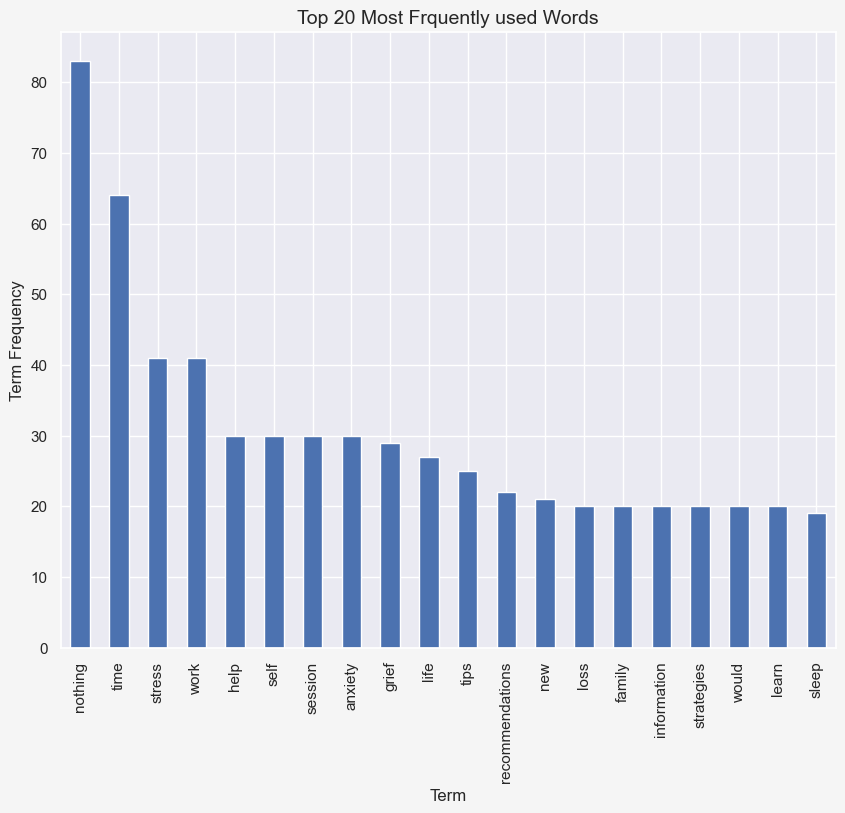

In [58]:
fig,ax = plt.subplots(figsize=(10,8), facecolor='whitesmoke')
tf_doc_term_df.sum().sort_values(ascending=False).head(20).plot(kind='bar', ax=ax)
ax.set_xlabel('Term', fontsize=12)
ax.set_ylabel('Term Frequency', fontsize=12)
ax.set_title('Top 20 Most Frquently used Words', fontsize=14)
save_figure(fig, FB_FIGURE_PATH, 'group_feedback_tf_')

In [59]:
print(len(tfidf_doc_term_df))
print(len(tfidf_doc_term_df.columns))
tfidf_doc_term_df.head(2)

428
1372


stress  affirmations  burnout  burnt  combat  feeling  know  need  \
0     1.0           0.0      0.0    0.0     0.0      0.0   0.0   0.0   
1     0.0           0.0      0.0    0.0     0.0      0.0   0.0   0.0   

   practical  ways  burn  dealing  general  hospital  instead  kept  real  \
0        0.0   0.0   0.0      0.0      0.0       0.0      0.0   0.0   0.0   
1        0.0   0.0   0.0      0.0      0.0       0.0      0.0   0.0   0.0   

   stressors  talk  talking  work  half  hour  make  overview  personal  ptsd  \
0        0.0   0.0      0.0   0.0   0.0   0.0   0.0       0.0       0.0   0.0   
1        0.0   0.0      0.0   0.0   0.0   0.0   0.0       0.0       0.0   0.0   

   brown  chat  depression  mindful  mrs  personable  questions  anxiety  \
0    0.0   0.0         0.0      0.0  0.0         0.0        0.0      0.0   
1    0.0   0.0         0.0      0.0  0.0         0.0        0.0      0.0   

   attended  back  backs  coming  conversation   dr  everyday  ive  keeps  \
0       0.0   0.0    0.0     0.0           0.0  0.0       0.0  0.0    0.0   
1       0.0   0.0    0.0     0.0           0.0  0.0       0.0  0.0    0.0   

   language  lily_brown  many  past  phenomenal  postpartum  ...  domestic  \
0       0.0         0.0   0.0   0.0         0.0         0.0  ...       0.0   
1       0.0         0.0   0.0   0.0         0.0         0.0  ...       0.0   

   survivor  head  watching  late  adapt  provoking  packed  present  skill  \
0       0.0   0.0       0.0   0.0    0.0        0.0     0.0      0.0    0.0   
1       0.0   0.0       0.0   0.0    0.0        0.0     0.0      0.0    0.0   

    bi  polar  survivors  conversations  example  listening  opposite  slide  \
0  0.0    0.0        0.0            0.0      0.0        0.0       0.0    0.0   
1  0.0    0.0        0.0            0.0      0.0        0.0       0.0    0.0   

   strengthen   eq  validated  middle  resilience  unable  interrupt  point  \
0         0.0  0.0        0.0     0.0         0.0     0.0        0.0    0.0   
1         0.0  0.0        0.0     0.0         0.0     0.0        0.0    0.0   

   seminar  actively  aspect  deeper  dive  facilitate  glad  mark  midday  \
0      0.0       0.0     0.0     0.0   0.0         0.0   0.0   0.0     0.0   
1      0.0       0.0     0.0     0.0   0.0         0.0   0.0   0.0     0.0   

   previous  response   vs  welcome  physiological  listner  adjustments  \
0       0.0       0.0  0.0      0.0            0.0      0.0          0.0   
1       0.0       0.0  0.0      0.0            0.0      0.0          0.0   

   negatively   pm  practicing  report  small  speak  guided  heart  
0         0.0  0.0         0.0     0.0    0.0    0.0     0.0    0.0  
1         0.0  0.0         0.0     0.0    0.0    0.0     0.0    0.0  

[2 rows x 1372 columns]

In [60]:
tfidf_doc_term_df.sum().sort_values(ascending=False).head(20)

nothing            11.1529
stress              8.0941
time                7.8812
work                6.5234
grief               6.0824
self                6.0477
anxiety             5.8458
life                5.7281
recommendations     5.6443
family              5.4239
sleep               5.3047
session             5.1017
tips                5.0014
loss                4.9014
strategies          4.8436
help                4.8207
learn               4.5227
care                4.3314
improve             4.2774
coping              4.1893
dtype: float64

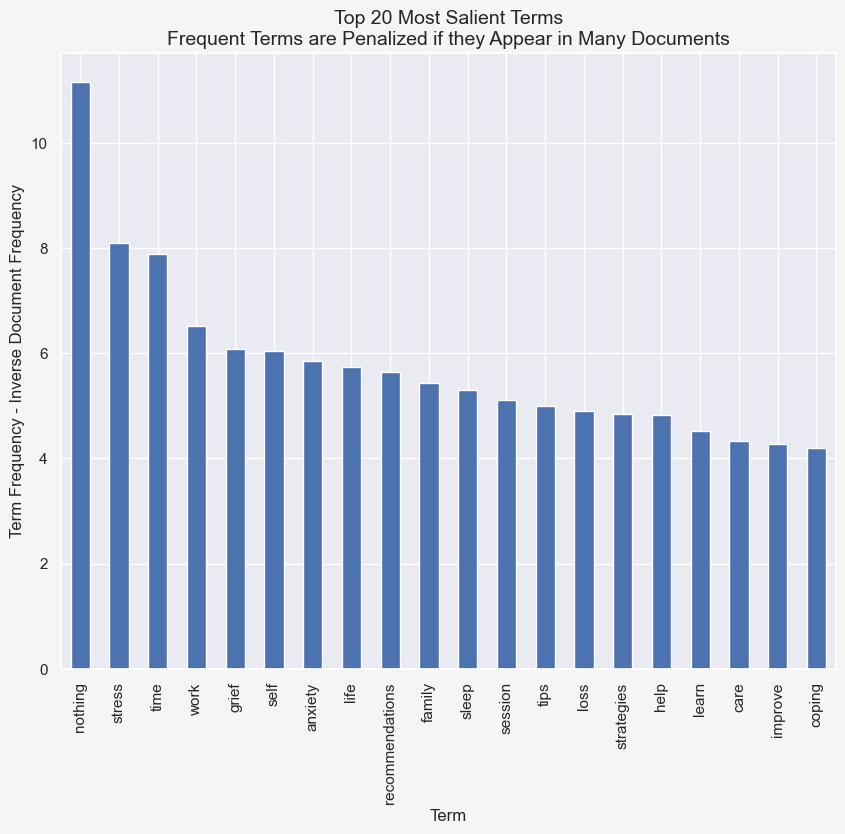

In [61]:
fig,ax = plt.subplots(figsize=(10,8), facecolor='whitesmoke')
tfidf_doc_term_df.sum().sort_values(ascending=False).head(20).plot(kind='bar', ax=ax)
ax.set_xlabel('Term', fontsize=12)
ax.set_ylabel('Term Frequency - Inverse Document Frequency', fontsize=12)
ax.set_title('Top 20 Most Salient Terms\nFrequent Terms are Penalized if they Appear in Many Documents', fontsize=14)
save_figure(fig, FB_FIGURE_PATH, 'group_feedback_tfidf_')

## LDA
* inputs = tf_doc_term, tfidf_doc_term

* Options to correct script, in order of time required, least to greatest (02/04/2022)
    * Gensim: pip install gensim==3.8.3 (IMPLEMENTED ON 02/05/2022)
    * Scikitlearn: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    * Gensim: https://radimrehurek.com/gensim/models/ldamodel.html
    * Mallet: https://github.com/maria-antoniak/little-mallet-wrapper

In [62]:
def eval_coherence(topics_dict, word_list, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_HDPmodel function
    word_list: list -> lemmatized word list of lists
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    score: float -> coherence value
    '''
    
    # Build gensim objects
    vocab = corpora.Dictionary(word_list)
    corpus = [vocab.doc2bow(words) for words in word_list]
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)
            
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    print("Evaluating topic coherence...")
    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list, 
                    coherence=coherence_type)
    
    score = cm.get_coherence()
    print ("Done\n")
    return score

In [63]:
def topics_to_wordclouds(model, topic_dict, topic_title, save_suffix, save=False):
    '''Wrapper function that generates wordclouds for ALL topics of a tomotopy model
    
    ** Inputs **
    model: obj -> tomotopy trained model
    topic_dic: dict -> per topic, an arrays with top words and associated frequencies
    save: bool -> If the user would like to save the images
    
    ** Returns **
    wordclouds as plots
    '''
    
    wcloud = WordCloud(background_color="white")
    fig, ax = plt.subplots(1, 3, figsize=(15,4))
    fig.suptitle(topic_title)

    cnt=0
    for k, arr in topic_dict.items():
        
        create_wordcloud(model, k, fig, ax[cnt], save_suffix, save)
        ax[cnt].title.set_text("Topic # " + str(k))
        cnt+=1
        
        if cnt==3:
            cnt=0
            fig, ax = plt.subplots(1, 3, figsize=(15,4))
    
    
              

def create_wordcloud(model, topic_idx, fig, ax, save_suffix, save=False):
    '''Wrapper function that generates individual wordclouds from topics in a tomotopy model
    
    ** Inputs **
    model: obj -> tomotopy trained model
    topic_idx: int -> topic index
    fig, ax: obj -> pyplot objects from subplots method
    save: bool -> If the user would like to save the images
    
    ** Returns **
    wordclouds as plots'''
    wcloud = WordCloud(background_color='white')
    
    topic_freqs = dict(model.get_topic_words(topic_idx))
    
    img = wcloud.generate_from_frequencies(topic_freqs)
    
    ax.imshow(img, interpolation='bilinear')
    ax.axis('off')
    
    if save:
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        img_name = f'wcloud_topic_{str(topic_idx)}_{save_suffix}.png'
        plt.savefig(''.join([FB_CLOUD_PATH,img_name]), bbox_inches=extent.expanded(1.1, 1.2))

### Train Models

In [64]:
tw_list = [tp.TermWeight.ONE, # all terms weighted equally
           tp.TermWeight.PMI, # Pointwise Mutual Information term weighting
           tp.TermWeight.IDF] # down-weights high frequency terms, upweights low freq ones
tw_names = ['one', 'pmi', 'idf']
tw_labels = ['Term Frequency','Pointwise Mutual Information','Inverse Document Frequency']
lda_model_topics = []
lda_model_doc_topics = []

# Train lda model
for i, term_weight in enumerate(tw_list):
    lda = tp.LDAModel(tw=term_weight, min_cf=0, rm_top=0, min_df=0, k=NUM_TOPICS)
    
    print("Model " + tw_names[i] )
    
    # Add docs to train
    for vec in data_words:
        lda.add_doc(vec)
    # Start Training
    lda.burn_in = 100
    lda.train(0)
    print('Num docs:', len(lda.docs), ', Vocab size:', len(lda.used_vocabs), ', Num words:', lda.num_words)
    print('Removed top words:', lda.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)
    lda.train(8000)
    lda.summary()
    
    print('Saving...', file=sys.stderr, flush=True)
    lda.save(''.join([FB_MODELS_PATH,'lda_model_',tw_names[i],".bin"]))

    
    # Get most important topics by # of times they were assigned (i.e. counts)
    topics=dict()
    sorted_topics = [k for k, v in sorted(enumerate(lda.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    for k in sorted_topics:
        topic_wp =[]
        for word, prob in lda.get_topic_words(k, top_n=WORD_COUNT):
            topic_wp.append((word, prob))
        topics[k] = topic_wp # store topic word/frequency array
    lda_model_topics.append(topics)
    
    doc_topic = []
    for doc in lda.docs:
        doc_topic.append(doc.get_topic_dist())
    lda_model_doc_topics.append(doc_topic)

Training...


Model one
Num docs: 347 , Vocab size: 1372 , Num words: 4045
Removed top words: []


Saving...
Training...


<Basic Info>
| LDAModel (current version: 0.12.5)
| 347 docs, 4045 words
| Total Vocabs: 1372, Used Vocabs: 1372
| Entropy of words: 6.62982
| Entropy of term-weighted words: 6.62982
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 8000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -7.88232
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 10 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 2400327922 (random seed)
| trained in version 0.12.5
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.5994382

Saving...
Training...


| LDAModel (current version: 0.12.5)
| 347 docs, 4045 words
| Total Vocabs: 1372, Used Vocabs: 1372
| Entropy of words: 6.62982
| Entropy of term-weighted words: 6.89606
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 8000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -6.34746
|
<Initial Parameters>
| tw: TermWeight.PMI
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 10 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 1073670902 (random seed)
| trained in version 0.12.5
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.04127919 0.019278   

Saving...


In [65]:
empty_idx = []
full_idx = []
for idx,content in enumerate(data_words):
    if len(content) == 0:
        empty_idx.append(idx)
    else:
        full_idx.append(idx)

In [66]:
coherence_scores = np.zeros(len(lda_model_topics))

for i, t in enumerate(lda_model_topics):
    print("Model " + tw_names[i] )
    coherence_scores[i] = eval_coherence(t, data_words)

Model one
Evaluating topic coherence...
Done

Model pmi
Evaluating topic coherence...
Done

Model idf
Evaluating topic coherence...
Done



#### Select "Best" Model

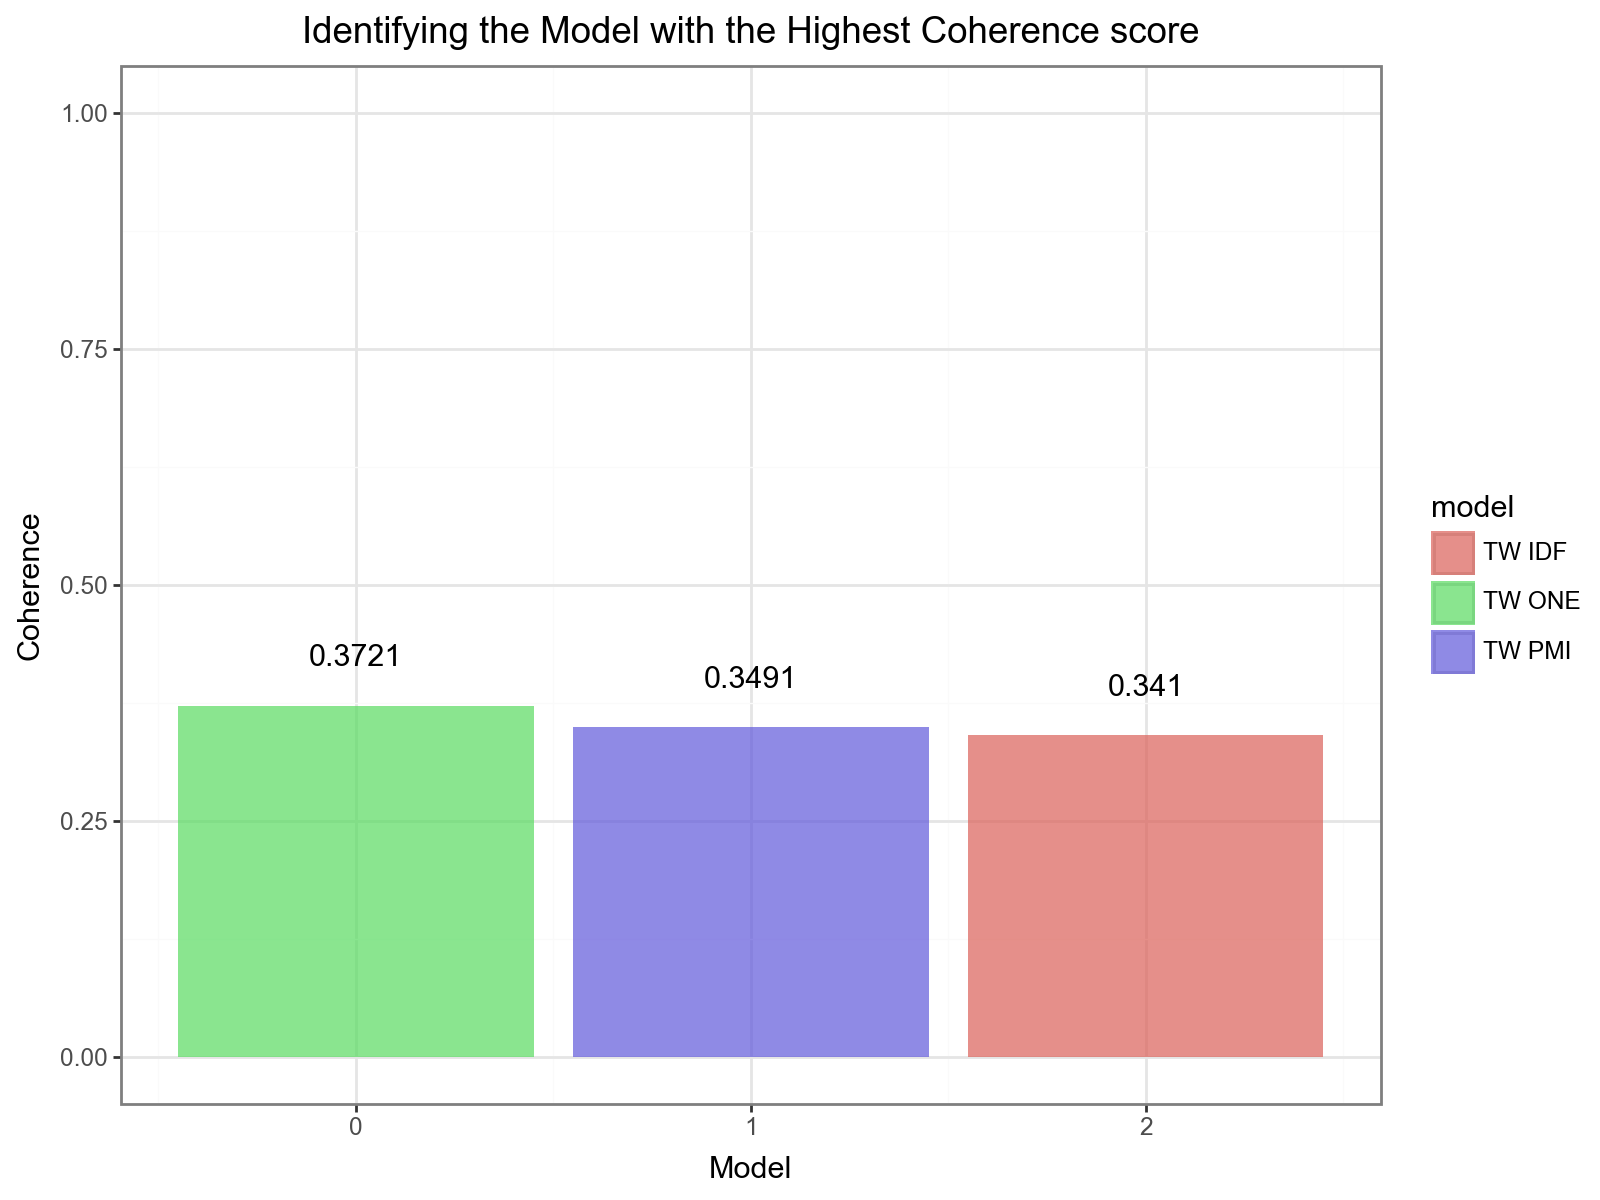

In [67]:
df_coherence = pd.DataFrame(coherence_scores).T
df_coherence.columns = ["TW ONE", "TW PMI", "TW IDF"]
df_coherence= df_coherence.melt(var_name="model").round(4)
df_coherence.reset_index(inplace=True)

(ggplot(df_coherence) +
 geom_bar(aes(x='index', y="value", fill="model"), 
          stat="identity", alpha=0.7) +
 geom_text(aes(x="index",y=df_coherence.value.values +0.05, label="value")) +
 theme_bw() +
 lims(y=(0,1)) +
 labs(y="Coherence", x="Model", title="Identifying the Model with the Highest Coherence score") + 
 theme(plot_title=element_text(ha=0.5), figure_size=(8,6))
)

In [68]:
LDA_results_dict = {f'{str(NUM_TOPICS)}_{name}':
                    {'topic_dict':lda_model_topics[idx],
                     'topic_title':f'Topic Wordclouds: {str(NUM_TOPICS)} Topics Weighted by {label}' ,
                     'doc_topic_array':lda_model_doc_topics[idx],
                     'doc_topic_title':f'Document Topic DataFrame: {str(NUM_TOPICS)} Topics Weighted by {label}',
                     'doc_topic_clustermap':f'Document Topic Hierarchical Clustering: {str(NUM_TOPICS)} Topics Weighted by {label}',
                     'save_suffix':f'{name}'} for idx,name,label in zip(range(len(tw_list)),tw_names,tw_labels)}

#### Term Frequency

In [69]:
topics_10_one = lda_model_topics[0]
doc_topics_10_one = pd.DataFrame(lda_model_doc_topics[0], index=full_idx, columns=TOPIC_LABELS)

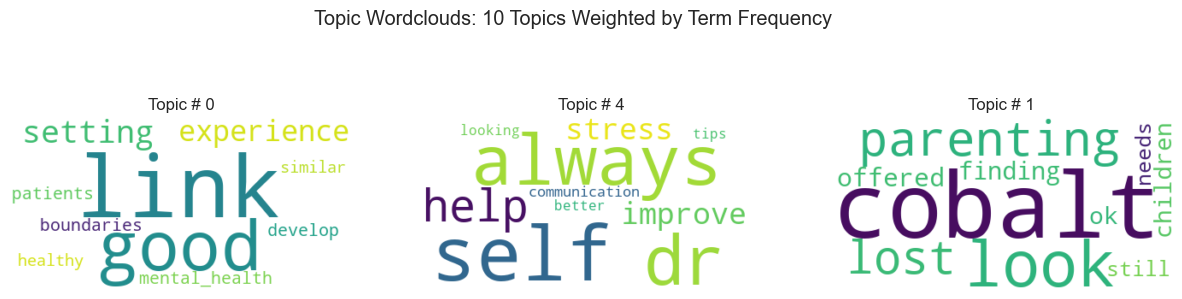

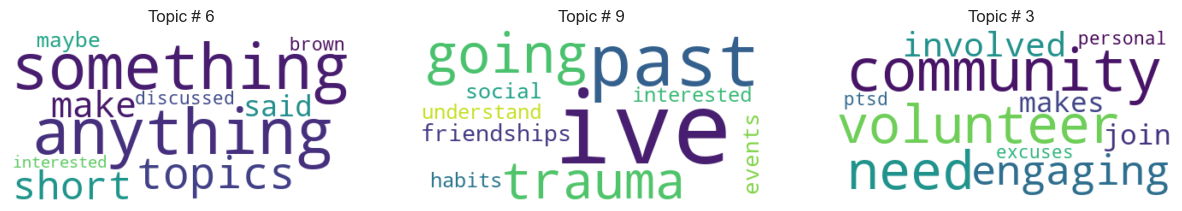

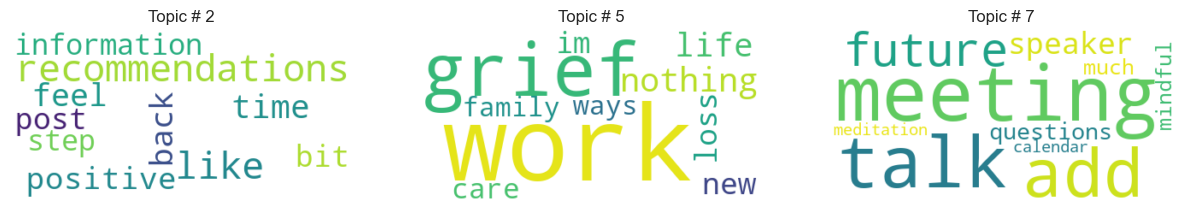

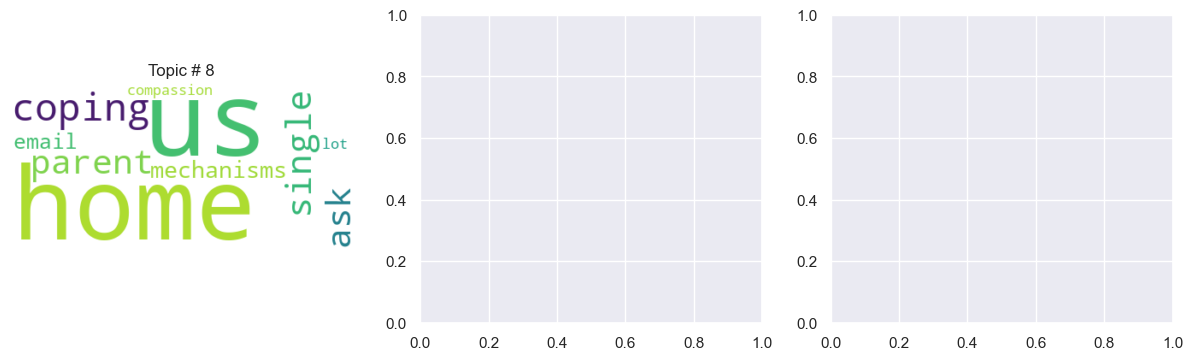

In [70]:
topics_to_wordclouds(lda, topics_10_one, LDA_results_dict['10_one']['topic_title'], LDA_results_dict['10_one']['save_suffix'], save=True)

In [71]:
save_name = FB_CHART_PATH + 'doc_10topic_tf_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
doc_topics_10_one.to_csv(save_name)
doc_topics_10_one

Topic_0  Topic_1  Topic_2  Topic_3  Topic_4  Topic_5  Topic_6  Topic_7  \
0     0.1474   0.0831   0.0476   0.0730   0.3453   0.0454   0.0818   0.0520   
2     0.2154   0.0280   0.0161   0.0246   0.3650   0.0153   0.0276   0.1833   
3     0.0398   0.0224   0.0129   0.2188   0.0268   0.0123   0.2212   0.3459   
4     0.0497   0.0280   0.0161   0.0246   0.0335   0.0153   0.7734   0.0175   
5     0.1589   0.0336   0.0192   0.1288   0.0402   0.3163   0.0331   0.0210   
..       ...      ...      ...      ...      ...      ...      ...      ...   
422   0.1282   0.2734   0.0924   0.0044   0.2893   0.0624   0.0050   0.1075   
423   0.2559   0.0240   0.0138   0.0211   0.4553   0.1553   0.0237   0.0150   
424   0.0398   0.0224   0.0129   0.0197   0.1596   0.0123   0.4203   0.2795   
426   0.2446   0.1396   0.0384   0.0096   0.0130   0.1347   0.2682   0.1356   
427   0.2863   0.0210   0.0121   0.0185   0.0252   0.5094   0.0207   0.0754   

     Topic_8  Topic_9  
0     0.0427   0.0816  
2     0.0973   0.0275  
3     0.0115   0.0884  
4     0.0144   0.0275  
5     0.2159   0.0330  
..       ...      ...  
422   0.0175   0.0199  
423   0.0124   0.0236  
424   0.0115   0.0220  
426   0.0056   0.0107  
427   0.0108   0.0207  

[347 rows x 10 columns]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:495: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:495: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


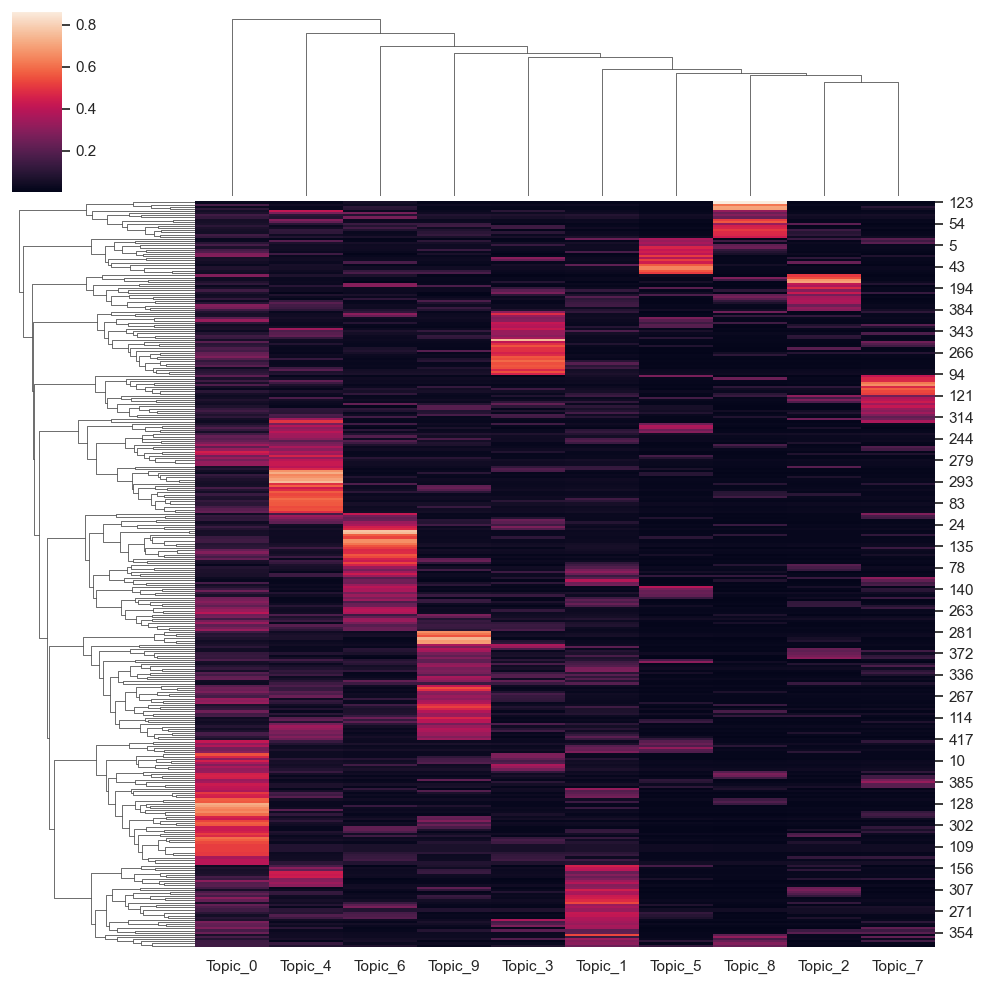

In [72]:
a = sns.clustermap(doc_topics_10_one)
save_figure(a, FB_FIGURE_PATH, 'doc_10topic_tf_clustermap_')

#### Pointwise Mutual Information

In [73]:
topics_10_pmi = lda_model_topics[1]
doc_topics_10_pmi = pd.DataFrame(lda_model_doc_topics[1], index=full_idx, columns=TOPIC_LABELS)

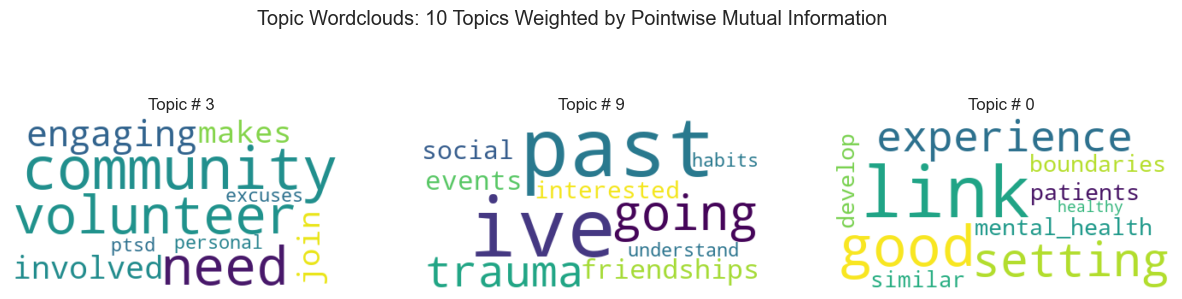

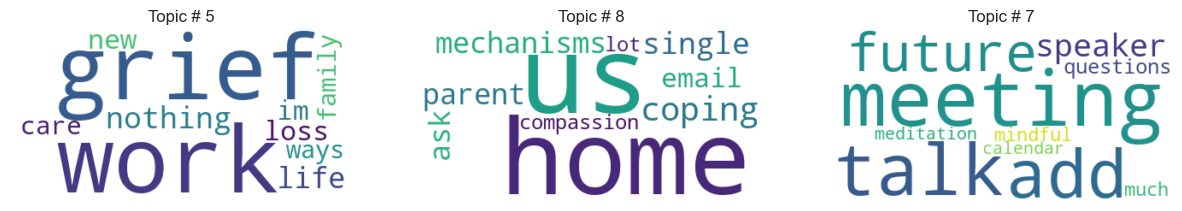

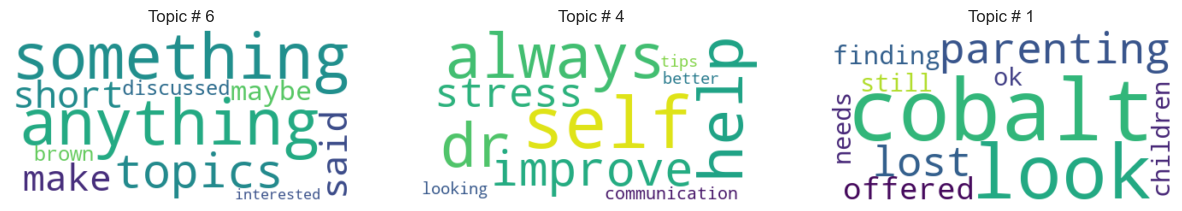

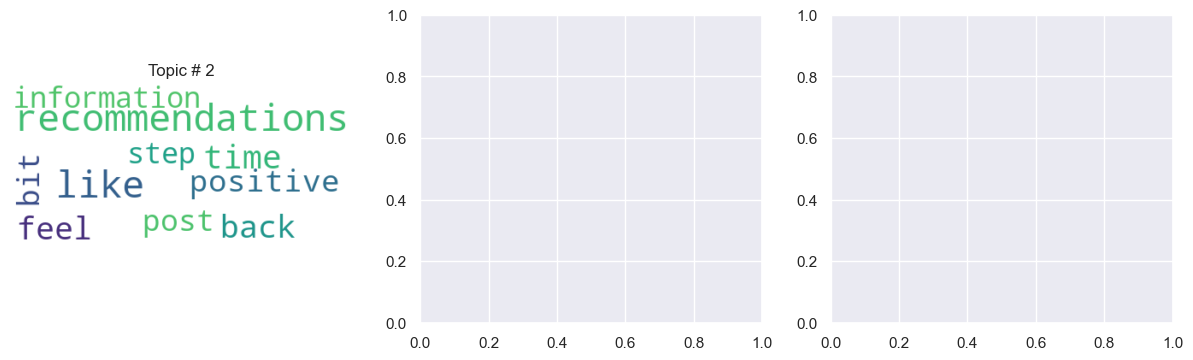

In [74]:
topics_to_wordclouds(lda, topics_10_pmi, LDA_results_dict['10_pmi']['topic_title'], LDA_results_dict['10_pmi']['save_suffix'], save=True)

In [75]:
save_name = FB_CHART_PATH + 'doc_10topic_pmi_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
doc_topics_10_pmi.to_csv(save_name)
doc_topics_10_pmi

Topic_0  Topic_1  Topic_2  Topic_3  Topic_4  Topic_5  Topic_6  Topic_7  \
0     0.0081   0.0038   0.0036   0.9566   0.0037   0.0047   0.0038   0.0056   
2     0.0010   0.0005   0.0005   0.6059   0.0005   0.0006   0.1518   0.0007   
3     0.0008   0.0004   0.0003   0.4568   0.5393   0.0005   0.0004   0.0005   
4     0.0009   0.0004   0.0004   0.0068   0.3070   0.0005   0.0004   0.6824   
5     0.0011   0.5999   0.0005   0.2649   0.0005   0.1304   0.0005   0.0008   
..       ...      ...      ...      ...      ...      ...      ...      ...   
422   0.1323   0.0427   0.0001   0.4789   0.0001   0.0296   0.3158   0.0002   
423   0.0009   0.0004   0.0004   0.9951   0.0004   0.0005   0.0004   0.0006   
424   0.0009   0.0004   0.0004   0.4686   0.5267   0.0006   0.0004   0.0007   
426   0.3811   0.0002   0.0002   0.1025   0.2390   0.0003   0.0002   0.2760   
427   0.6833   0.0003   0.0003   0.1679   0.0003   0.1462   0.0003   0.0005   

     Topic_8  Topic_9  
0     0.0041   0.0061  
2     0.2378   0.0008  
3     0.0004   0.0006  
4     0.0005   0.0007  
5     0.0006   0.0009  
..       ...      ...  
422   0.0001   0.0002  
423   0.0005   0.0007  
424   0.0005   0.0007  
426   0.0002   0.0003  
427   0.0004   0.0005  

[347 rows x 10 columns]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:495: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:495: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


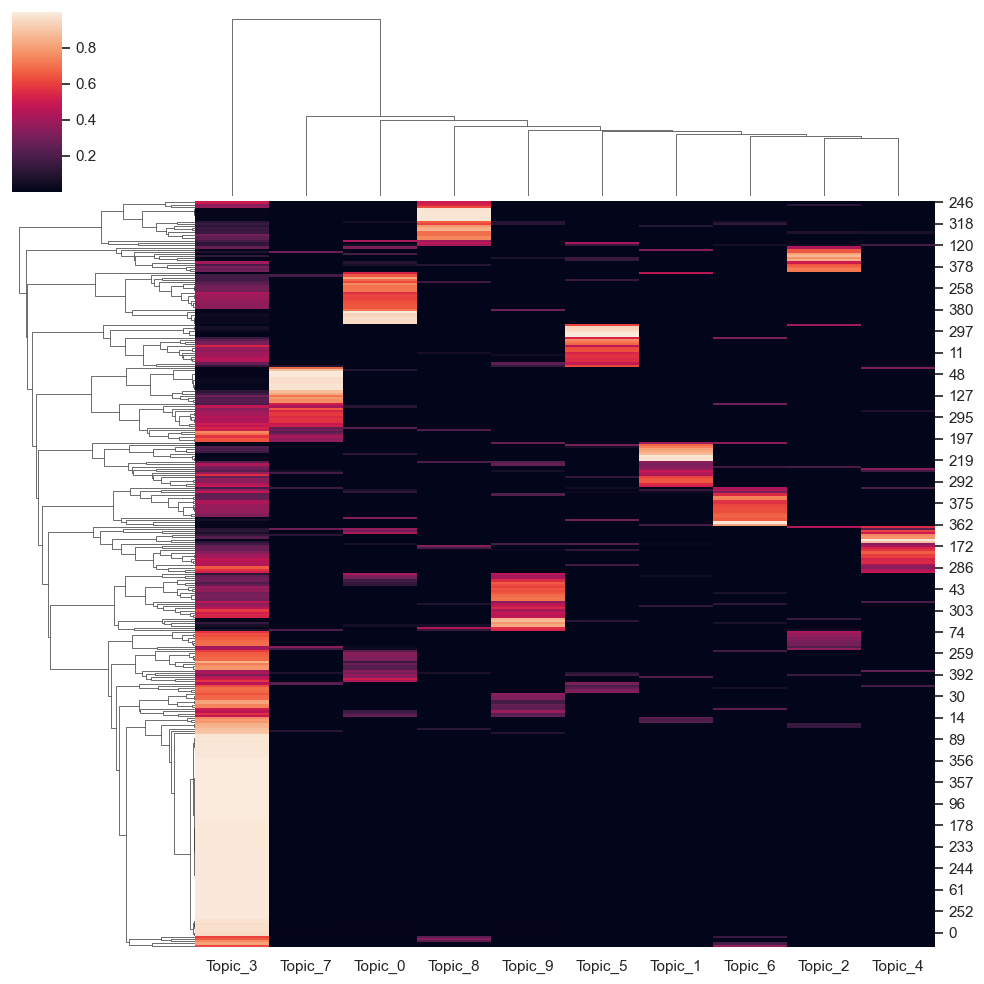

In [76]:
a = sns.clustermap(doc_topics_10_pmi)
save_figure(a, FB_FIGURE_PATH, 'doc_10topic_pmi_clustermap_')

#### Inverse Document Frequency

In [77]:
topics_10_idf = lda_model_topics[2]
doc_topics_10_idf = pd.DataFrame(lda_model_doc_topics[2], index=full_idx, columns=TOPIC_LABELS)

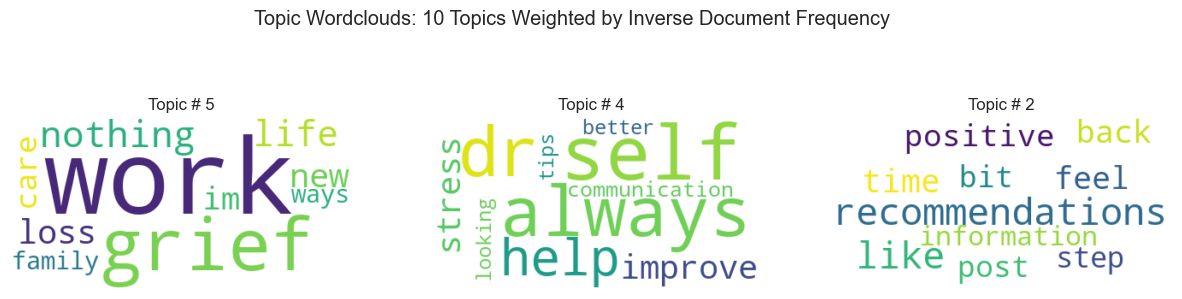

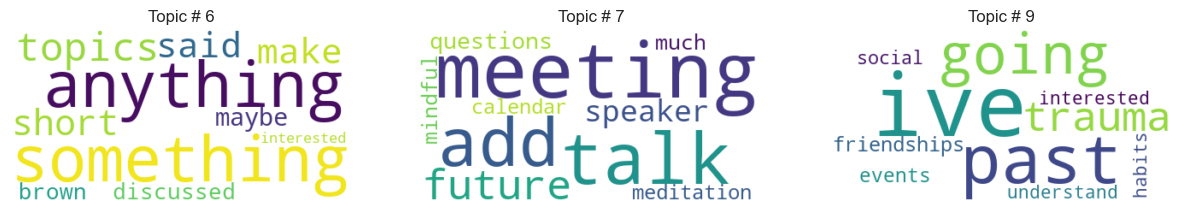

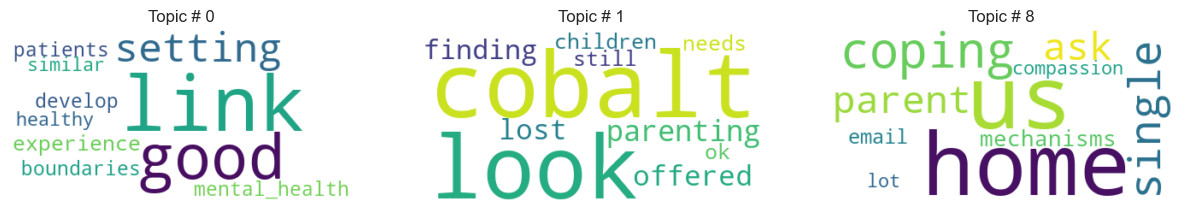

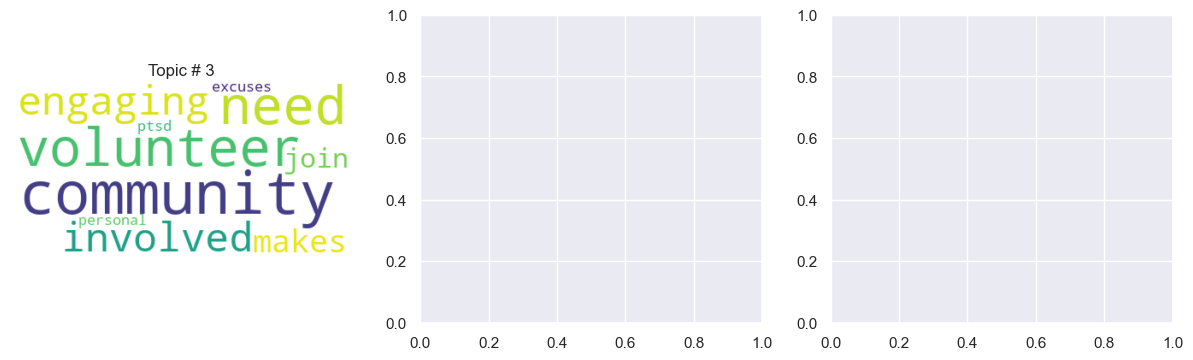

In [79]:
topics_to_wordclouds(lda, topics_10_idf, LDA_results_dict['10_idf']['topic_title'], LDA_results_dict['10_idf']['save_suffix'], save=True)

In [80]:
save_name = FB_CHART_PATH + 'doc_10topic_idf_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
doc_topics_10_idf.to_csv(save_name)
doc_topics_10_idf

Topic_0  Topic_1  Topic_2     Topic_3  Topic_4  Topic_5  Topic_6  \
0     0.0069   0.0074   0.0118  4.8607e-03   0.8679   0.0686   0.0086   
2     0.0005   0.0005   0.0009  3.5540e-04   0.3233   0.6721   0.0006   
3     0.0004   0.0004   0.0006  2.6108e-04   0.0021   0.7222   0.0005   
4     0.0005   0.0005   0.0008  9.8895e-01   0.0026   0.0046   0.0006   
5     0.0006   0.0006   0.0010  4.1319e-04   0.1217   0.0058   0.4839   
..       ...      ...      ...         ...      ...      ...      ...   
422   0.0181   0.1208   0.0001  4.7616e-05   0.2683   0.1510   0.3150   
423   0.0004   0.0005   0.0007  3.0364e-04   0.9917   0.0043   0.0005   
424   0.0004   0.0005   0.0007  3.0679e-04   0.0025   0.7048   0.0005   
426   0.0002   0.0002   0.0748  2.9261e-01   0.1983   0.0016   0.0002   
427   0.0003   0.0004   0.0006  2.3311e-04   0.1256   0.1232   0.0004   

        Topic_7     Topic_8  Topic_9  
0    9.8495e-03  7.2541e-03   0.0069  
2    7.2002e-04  5.3030e-04   0.0005  
3    2.7281e-01  3.8964e-04   0.0004  
4    6.5804e-04  4.8464e-04   0.0005  
5    3.8483e-01  6.1665e-04   0.0006  
..          ...         ...      ...  
422  9.6529e-05  7.2783e-05   0.1264  
423  6.1527e-04  4.5315e-04   0.0004  
424  2.8936e-01  4.5783e-04   0.0004  
426  4.3182e-01  1.7012e-04   0.0002  
427  7.4858e-01  3.7156e-04   0.0003  

[347 rows x 10 columns]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:495: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:495: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


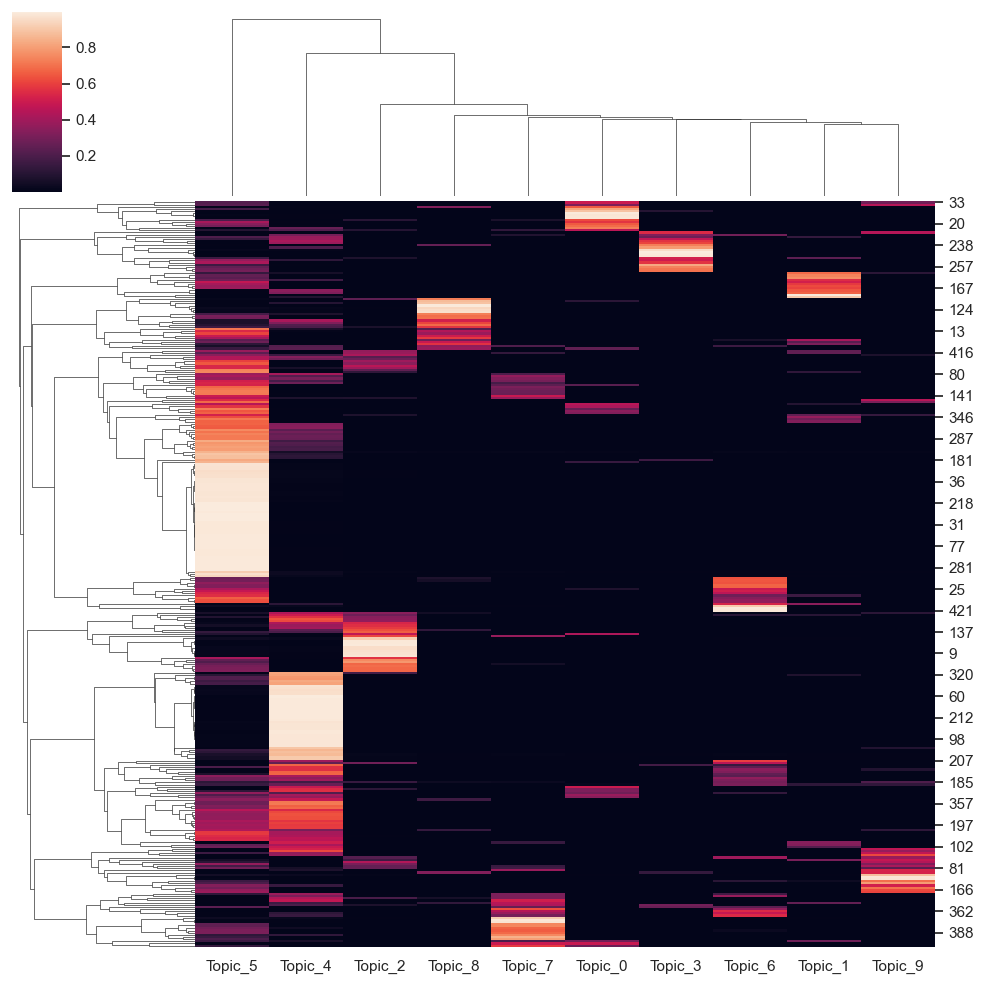

In [81]:
a = sns.clustermap(doc_topics_10_idf)
save_figure(a, FB_FIGURE_PATH, 'doc_10topic_idf_clustermap_')

### Correlation Analysis

In [82]:
all_data_df.head(2)

survey_timestamp  recommend_rating what_motivated what_helpful  \
0 2023-06-21 10:20:09               7.0         stress          all   
1 2023-06-21 10:33:07               6.0      the topic          NaN   

  what_change           how_often how_often_other  \
0         NaN  every three months             NaN   
1         NaN         every month             NaN   

                       days_week       times_day future_topics  \
0  tuesday,,wednesdsay,,thursday  monring,,lunch           NaN   
1                monday,,tuesday   morning,lunch           NaN   

  referral_source host_name session_date                       session_name  \
0       pm report     erica   2023-06-14  staying effective when burned out   
1       pm report     erica   2023-06-14  staying effective when burned out   

   record_id_orig  response_id_orig  session_id_orig as often as offered  \
0               0                 0                0               False   
1               1                 1                0               False   

  every month every six months every three months every two months  \
0       False            False               True            False   
1        True            False              False            False   

  not interested often_other  Mon  Tue  Wed  Thu  Fri  Sat  Sun  afternoon  \
0          False       False    0    1    1    1    0    0    0          0   
1          False       False    1    1    0    0    0    0    0          0   

   evening  lunch  morning  cobalt  email  friend/colleague   hr  limeaid  \
0        0      1        1     0.0      0                 0  0.0        0   
1        0      1        1     0.0      0                 0  0.0        0   

   referral_other  pm report  poster/flyer  wellfocused resp_concat_text  \
0               0          1           0.0            0       stress all   
1               0          1           0.0            0        the topic   

   resp_concat_text_wc  learn_skills_rating  use_skills_rating  \
0                    2                  NaN                NaN   
1                    2                  NaN                NaN   

   cope_wellbeng_rating  satisfied_session_rating  host_id  session_id  \
0                   NaN                       NaN        0           0   
1                   NaN                       NaN        0           0   

   response_id  record_id  
0            0          0  
1            1          1

In [83]:
# shared question columns
common_questions_short = ['what_motivated','what_helpful','what_change','future_topics',
                          'days_week','times_day','referral_source','host_name','session_date','session_name']
all_data_common = all_data_df[common_questions_short]
#all_data_common['host_name'] = all_data_common['host_name'].apply(lambda x: 0 if x=='erica' else 1)
all_data_common.head(2)

what_motivated what_helpful what_change future_topics  \
0         stress          all         NaN           NaN   
1      the topic          NaN         NaN           NaN   

                       days_week       times_day referral_source host_name  \
0  tuesday,,wednesdsay,,thursday  monring,,lunch       pm report     erica   
1                monday,,tuesday   morning,lunch       pm report     erica   

  session_date                       session_name  
0   2023-06-14  staying effective when burned out  
1   2023-06-14  staying effective when burned out

In [84]:
host_dummies = pd.get_dummies(all_data_common['host_name'])
host_dummies.head(2)

erica   lily
0   True  False
1   True  False

#### Merge with topic data

In [85]:
doc_topics_10_one_host = doc_topics_10_one.merge(host_dummies, how='inner', left_index=True, right_index=True)
doc_topics_10_one_host.head(2)

Topic_0  Topic_1  Topic_2  Topic_3  Topic_4  Topic_5  Topic_6  Topic_7  \
0   0.1474   0.0831   0.0476   0.0730   0.3453   0.0454   0.0818   0.0520   
2   0.2154   0.0280   0.0161   0.0246   0.3650   0.0153   0.0276   0.1833   

   Topic_8  Topic_9  erica   lily  
0   0.0427   0.0816   True  False  
2   0.0973   0.0275   True  False

#### Correlation

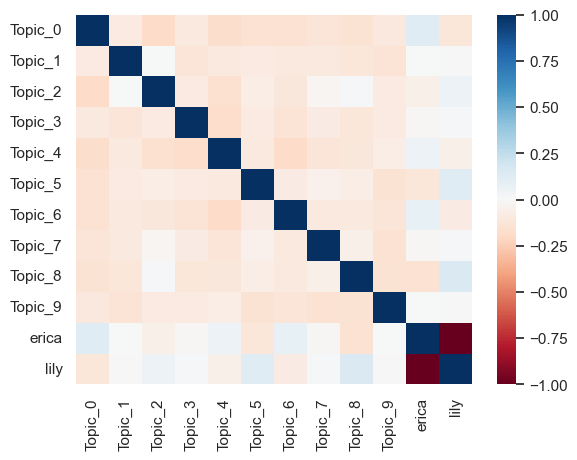

In [87]:
a = sns.heatmap(doc_topics_10_one_host.corr(),cmap='RdBu')
fig = a.figure
save_figure(fig, FB_FIGURE_PATH, 'doc_10topic_tf_corr_heatmap_')

In [116]:
doc_topics_10_one_host.corr().sort_values('erica', ascending=False)

Topic_0  Topic_1  Topic_2  Topic_3  Topic_4  Topic_5  Topic_6  \
erica     0.0032  -0.1227  -0.2043   0.1253  -0.0275  -0.0833   0.0867   
Topic_3   0.0107  -0.0845  -0.0563   1.0000  -0.1539  -0.0557  -0.0967   
Topic_6  -0.1255  -0.1461  -0.0558  -0.0967  -0.1285  -0.1028   1.0000   
Topic_8  -0.1714  -0.1449  -0.1109  -0.2442  -0.0972  -0.1074  -0.0898   
Topic_7  -0.1030  -0.1441  -0.0968  -0.0426  -0.1554  -0.0787  -0.0905   
Topic_9  -0.1425  -0.0344  -0.1095  -0.1037  -0.1110  -0.1156  -0.1874   
Topic_0   1.0000   0.0027  -0.1235   0.0107  -0.1699  -0.0921  -0.1255   
Topic_4  -0.1699  -0.1357  -0.0556  -0.1539   1.0000  -0.1227  -0.1285   
Topic_5  -0.0921  -0.0769  -0.0912  -0.0557  -0.1227   1.0000  -0.1028   
Topic_1   0.0027   1.0000  -0.0773  -0.0845  -0.1357  -0.0769  -0.1461   
Topic_2  -0.1235  -0.0773   1.0000  -0.0563  -0.0556  -0.0912  -0.0558   
lily     -0.0032   0.1227   0.2043  -0.1253   0.0275   0.0833  -0.0867   

         Topic_7  Topic_8  Topic_9   erica    lily  
erica     0.0606   0.0667   0.0183  1.0000 -1.0000  
Topic_3  -0.0426  -0.2442  -0.1037  0.1253 -0.1253  
Topic_6  -0.0905  -0.0898  -0.1874  0.0867 -0.0867  
Topic_8  -0.2106   1.0000  -0.1419  0.0667 -0.0667  
Topic_7   1.0000  -0.2106  -0.1211  0.0606 -0.0606  
Topic_9  -0.1211  -0.1419   1.0000  0.0183 -0.0183  
Topic_0  -0.1030  -0.1714  -0.1425  0.0032 -0.0032  
Topic_4  -0.1554  -0.0972  -0.1110 -0.0275  0.0275  
Topic_5  -0.0787  -0.1074  -0.1156 -0.0833  0.0833  
Topic_1  -0.1441  -0.1449  -0.0344 -0.1227  0.1227  
Topic_2  -0.0968  -0.1109  -0.1095 -0.2043  0.2043  
lily     -0.0606  -0.0667  -0.0183 -1.0000  1.0000

In [117]:
doc_topics_10_one_host.corr().sort_values('lily', ascending=False)

Topic_0  Topic_1  Topic_2  Topic_3  Topic_4  Topic_5  Topic_6  \
lily     -0.0032   0.1227   0.2043  -0.1253   0.0275   0.0833  -0.0867   
Topic_2  -0.1235  -0.0773   1.0000  -0.0563  -0.0556  -0.0912  -0.0558   
Topic_1   0.0027   1.0000  -0.0773  -0.0845  -0.1357  -0.0769  -0.1461   
Topic_5  -0.0921  -0.0769  -0.0912  -0.0557  -0.1227   1.0000  -0.1028   
Topic_4  -0.1699  -0.1357  -0.0556  -0.1539   1.0000  -0.1227  -0.1285   
Topic_0   1.0000   0.0027  -0.1235   0.0107  -0.1699  -0.0921  -0.1255   
Topic_9  -0.1425  -0.0344  -0.1095  -0.1037  -0.1110  -0.1156  -0.1874   
Topic_7  -0.1030  -0.1441  -0.0968  -0.0426  -0.1554  -0.0787  -0.0905   
Topic_8  -0.1714  -0.1449  -0.1109  -0.2442  -0.0972  -0.1074  -0.0898   
Topic_6  -0.1255  -0.1461  -0.0558  -0.0967  -0.1285  -0.1028   1.0000   
Topic_3   0.0107  -0.0845  -0.0563   1.0000  -0.1539  -0.0557  -0.0967   
erica     0.0032  -0.1227  -0.2043   0.1253  -0.0275  -0.0833   0.0867   

         Topic_7  Topic_8  Topic_9   erica    lily  
lily     -0.0606  -0.0667  -0.0183 -1.0000  1.0000  
Topic_2  -0.0968  -0.1109  -0.1095 -0.2043  0.2043  
Topic_1  -0.1441  -0.1449  -0.0344 -0.1227  0.1227  
Topic_5  -0.0787  -0.1074  -0.1156 -0.0833  0.0833  
Topic_4  -0.1554  -0.0972  -0.1110 -0.0275  0.0275  
Topic_0  -0.1030  -0.1714  -0.1425  0.0032 -0.0032  
Topic_9  -0.1211  -0.1419   1.0000  0.0183 -0.0183  
Topic_7   1.0000  -0.2106  -0.1211  0.0606 -0.0606  
Topic_8  -0.2106   1.0000  -0.1419  0.0667 -0.0667  
Topic_6  -0.0905  -0.0898  -0.1874  0.0867 -0.0867  
Topic_3  -0.0426  -0.2442  -0.1037  0.1253 -0.1253  
erica     0.0606   0.0667   0.0183  1.0000 -1.0000

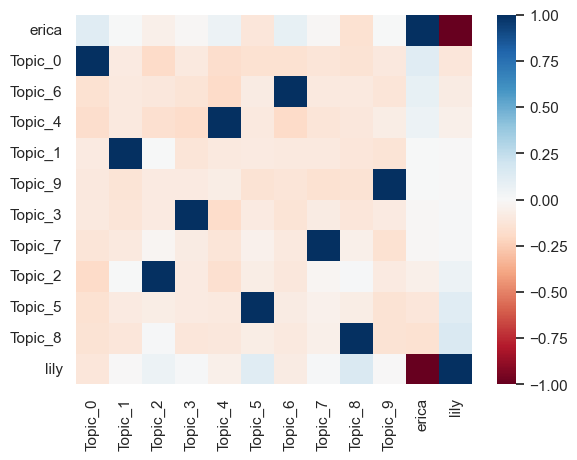

In [88]:
a = sns.heatmap(doc_topics_10_one_host.corr().sort_values('erica', ascending=False), cmap='RdBu')
fig = a.figure
save_figure(fig, FB_FIGURE_PATH, 'doc_10topic_tf_corr_heatmap_sorted_')

### Gensim Models

#### Train Models

In [89]:
# gensim topic model
ldagensim = gensim.models.ldamodel.LdaModel(corpus=corpus,num_topics=NUM_TOPICS,id2word=id2word,gamma_threshold=0.001, iterations=4000)
#ldagensimConvert = gensim.models.wrappers.ldagensim.gensimmodel2ldamodel(ldagensim, gamma_threshold=0.001, iterations=100)

In [90]:
# Show topics and coherence score
pprint(ldagensim.show_topics(num_topics=NUM_TOPICS,num_words=WORD_COUNT,formatted=False))
coherence_model_ldagensim = CoherenceModel(model=ldagensim, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_ldagensim = coherence_model_ldagensim.get_coherence()
print('\nCoherence Score: ', coherence_ldagensim)

[(0,
  [('session', 0.014483721),
   ('make', 0.012696991),
   ('information', 0.012696787),
   ('nothing', 0.012696085),
   ('longer', 0.009119955),
   ('dr', 0.009119702),
   ('recommendations', 0.009118959),
   ('helpful', 0.0073320535),
   ('new', 0.0073317788),
   ('wanted', 0.0073314877),
   ('dealing', 0.007331472),
   ('always', 0.007331436),
   ('time', 0.007331255),
   ('offered', 0.0055435053),
   ('resources', 0.005543484)]),
 (1,
  [('time', 0.014906018),
   ('self', 0.012462491),
   ('nothing', 0.012462076),
   ('looking', 0.010018539),
   ('advice', 0.0075755254),
   ('us', 0.007575493),
   ('learn', 0.0075750942),
   ('resources', 0.007574853),
   ('people', 0.0075748125),
   ('work', 0.0075740796),
   ('short', 0.0051318672),
   ('anxiety', 0.0051316414),
   ('excellent', 0.0051316093),
   ('friend', 0.0051316074),
   ('sessions', 0.005131597)]),
 (2,
  [('nothing', 0.021489847),
   ('work', 0.011647417),
   ('session', 0.011647074),
   ('time', 0.008366952),
   ('anxi

#### Save Models

In [91]:
corpus_name = FB_MODELS_PATH + 'corpus_' + DOC_SRC + 'Data_' + str(datetime.datetime.now().date()).replace('-','') + '.pkl'
dict_name = FB_MODELS_PATH + 'id2word_' + DOC_SRC + 'Data_' + str(datetime.datetime.now().date()).replace('-','') + '.gensim'
model_name = FB_MODELS_PATH + 'ldagensim_' + str(NUM_TOPICS)+ 'topics_' + DOC_SRC + 'Data_' + str(datetime.datetime.now().date()).replace('-','') + '.gensim'

pickle.dump(corpus, open(corpus_name, 'wb'))
id2word.save(dict_name)
ldagensim.save(model_name)

#### Load Models

In [92]:
gensim_corpus = pickle.load(open(corpus_name, 'rb'))
gensim_dictionary = gensim.corpora.Dictionary.load(dict_name)
lda_model = gensim.models.ldamodel.LdaModel.load(model_name)

In [93]:
# visualize - sometimes works better immediately after loading models
lda_visualization = pyLDAvis.gensim.prepare(lda_model, gensim_corpus, gensim_dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)
pyLDAvis.save_html(lda_visualization, 'gensim_lda_10topic_tf.html')

### Model Output

#### Doc-Topic

In [94]:
# Doc-topic matrix
doc_ldagensim = ldagensim[corpus]
doc_topic = pd.DataFrame([[topic[1] for topic in doc] for doc in doc_ldagensim], columns=TOPIC_LABELS)

# Save
name = FB_CHART_PATH + 'doc_' +  str(NUM_TOPICS) + 'topics_'  + DOC_SRC + 'Data_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
doc_topic.to_csv(name)

In [95]:
print(len(doc_topic))
print(len(doc_topic.columns))
doc_topic.head(5)

428
10


Topic_0  Topic_1  Topic_2  Topic_3  Topic_4  Topic_5  Topic_6  Topic_7  \
0   0.0500     0.05     0.05     0.05     0.05   0.5499     0.05     0.05   
1   0.1000     0.10     0.10     0.10     0.10   0.1000     0.10     0.10   
2   0.0100     0.01     0.01     0.01     0.01   0.0100     0.01     0.01   
3   0.9308      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4   0.9100     0.01     0.01     0.01     0.01   0.0100     0.01     0.01   

   Topic_8  Topic_9  
0     0.05     0.05  
1     0.10     0.10  
2     0.91     0.01  
3      NaN      NaN  
4     0.01     0.01

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:495: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:495: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


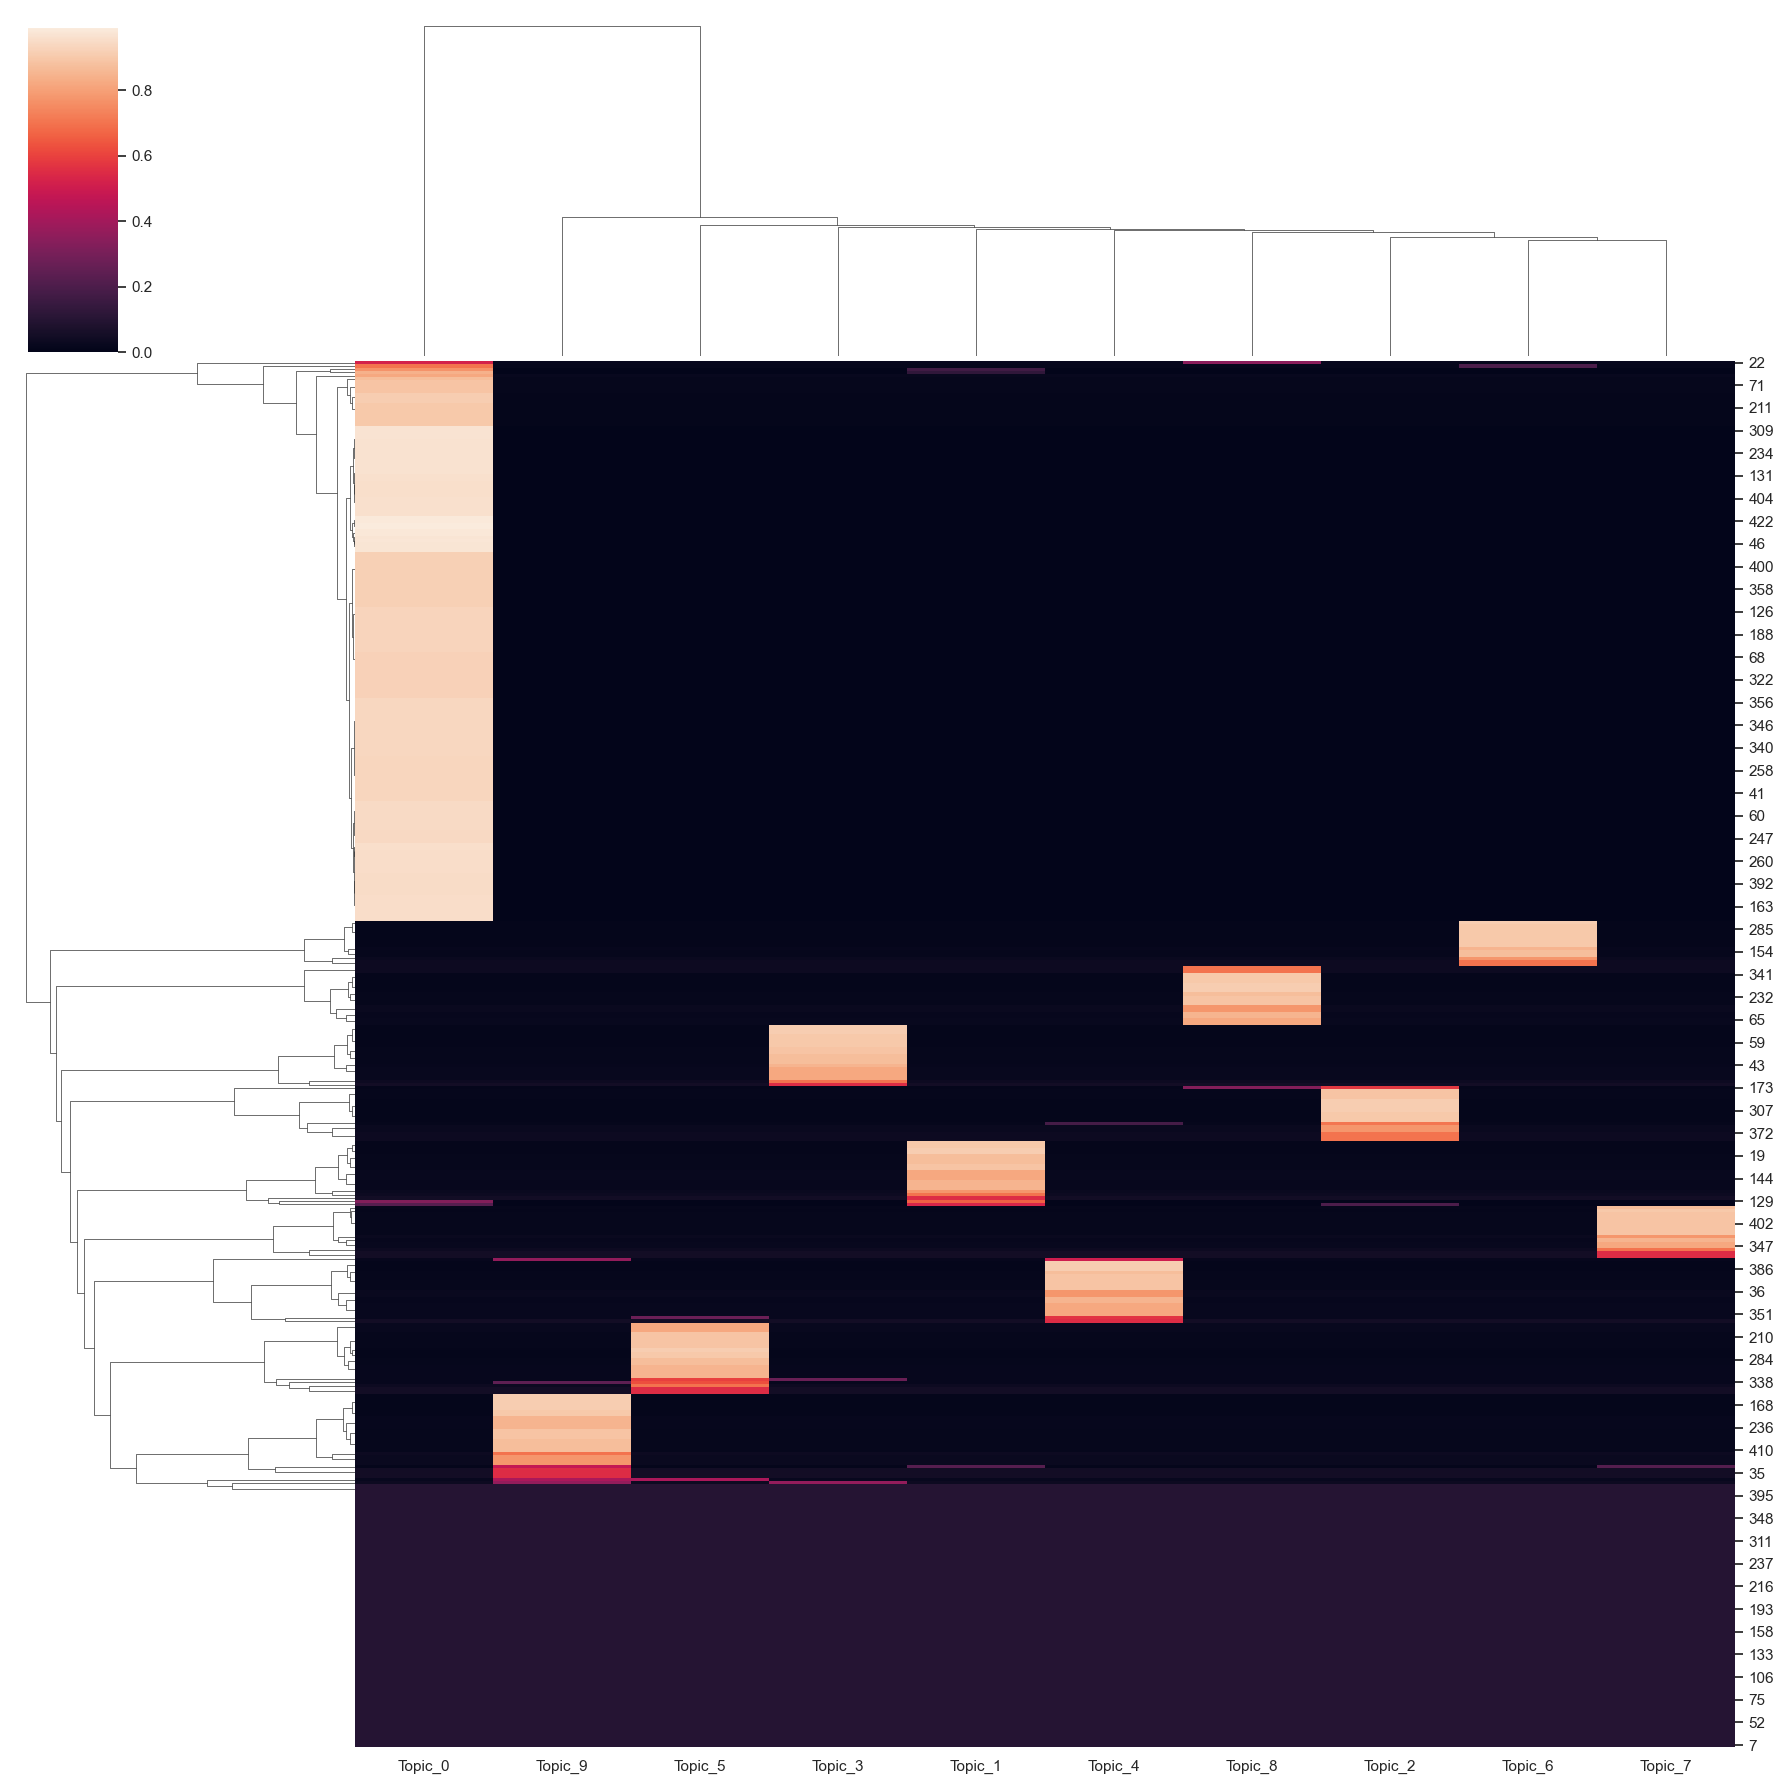

In [97]:
a = sns.clustermap(doc_topic.fillna(0), figsize=(18,18))
save_figure(a, FB_FIGURE_PATH, 'gensim_lda_10topic_tfidf_clustermap_')

#### Topic-Term

In [98]:
# Topic-term matix
topic_term = get_topic_terms(ldagensim,num_topics=NUM_TOPICS,word_count=WORD_COUNT)
topic_term = topic_term.transpose()

# Save
name = FB_TOPIC_PATH + str(NUM_TOPICS) + 'topic_terms_' + DOC_SRC + 'Data_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
topic_term.to_csv(name)

In [99]:
print(len(topic_term))
print(len(topic_term.columns))
topic_term.head(5)

20
15


Word_1  Word_2       Word_3   Word_4   Word_5  Word_6  \
Topic_0 word   session    make  information  nothing   longer      dr   
        value   0.0145  0.0127       0.0127   0.0127   0.0091  0.0091   
Topic_1 word      time    self      nothing  looking   advice      us   
        value   0.0149  0.0125       0.0125     0.01   0.0076  0.0076   
Topic_2 word   nothing    work      session     time  anxiety  stress   

                        Word_7     Word_8  Word_9 Word_10  Word_11  Word_12  \
Topic_0 word   recommendations    helpful     new  wanted  dealing   always   
        value           0.0091     0.0073  0.0073  0.0073   0.0073   0.0073   
Topic_1 word             learn  resources  people    work    short  anxiety   
        value           0.0076     0.0076  0.0076  0.0076   0.0051   0.0051   
Topic_2 word            cobalt       link    help     one     tips    needs   

                 Word_13  Word_14    Word_15  
Topic_0 word        time  offered  resources  
        value     0.0073   0.0055     0.0055  
Topic_1 word   excellent   friend   sessions  
        value     0.0051   0.0051     0.0051  
Topic_2 word     balance   family      would

#### Topic Top Words

In [100]:
# Topic term - separate words and values
topic_term_words = topic_term.xs("word", level=1, axis=0)
topic_term_values = topic_term.xs("value", level=1, axis=0)

# Formatted top words per topic
topic_term_topWords = topic_term_words.agg(', '.join, axis=1)
topic_term_topWords = pd.DataFrame(topic_term_topWords, columns=['top_words'])
topic_term_topWords.index.name = 'topic_num'

# Columns for reviewer coding
topic_term_topWords['coded_theme_reviewer1'] = ''
topic_term_topWords['coded_theme_reviewer2'] = ''
topic_term_topWords['coded_theme_reviewer3'] = ''
topic_term_topWords['combined_theme'] = ''

# Save
name = FB_TOPIC_PATH + str(NUM_TOPICS) + 'topic_topWords_' + DOC_SRC + 'Data_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
topic_term_topWords.to_csv(name)

In [101]:
print(len(topic_term_topWords))
print(len(topic_term_topWords.columns))
topic_term_topWords.head()

10
5


top_words  \
topic_num                                                                                                        
Topic_0    session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
Topic_1    time, self, nothing, looking, advice, us, learn, resources, people, work, short, anxiety, excell...   
Topic_2    nothing, work, session, time, anxiety, stress, cobalt, link, help, one, tips, needs, balance, fa...   
Topic_3    nothing, anxiety, tips, strategies, year, helpful, learning, life, stress, time, new, day, speci...   
Topic_4    time, grief, self, nothing, past, ive, dr, longer, everything, anxiety, presented, lily_brown, s...   

          coded_theme_reviewer1 coded_theme_reviewer2 coded_theme_reviewer3  \
topic_num                                                                     
Topic_0                                                                       
Topic_1                                                                       
Topic_2                                                                       
Topic_3                                                                       
Topic_4                                                                       

          combined_theme  
topic_num                 
Topic_0                   
Topic_1                   
Topic_2                   
Topic_3                   
Topic_4

#### Topic Top Docs

In [102]:
# Prep doc_topic matrix
doc_topic_sort = doc_topic.copy()
doc_topic_sort['dominant_topic'] = doc_topic_sort.idxmax(axis=1)
doc_topic_sort = doc_topic_sort.merge(data_df[['resp_concat_text','session_name','session_date','host_name']], how='inner', left_index=True, right_index=True)

# Get top docs
top_docs_topic_cols = ['topic_id','topic_top_words','resp_concat_text','dominant_topic','session_name','session_date','host_name']
top_docs_topic = pd.DataFrame(columns=top_docs_topic_cols)
for col in TOPIC_LABELS:
    sorted_df = doc_topic_sort.sort_values(col, ascending=False).drop_duplicates('resp_concat_text').head(15).copy()
    sorted_df['topic_id'] = col
    sorted_df['topic_top_words'] = topic_term_topWords['top_words'].at[col]
    sorted_df = sorted_df[top_docs_topic_cols]
    top_docs_topic = pd.concat([top_docs_topic,sorted_df])
    
# Save
name = FB_TOPIC_PATH + str(NUM_TOPICS) + 'topic_topDocs_' + DOC_SRC + 'Data_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
top_docs_topic.to_csv(name)

/var/folders/76/d55vnsd57r14x_v2bpwdqnnm0000gn/T/ipykernel_5883/845295218.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [103]:
print(len(top_docs_topic))
print(len(top_docs_topic.columns))
top_docs_topic.head()

150
7


topic_id  \
185  Topic_0   
120  Topic_0   
422  Topic_0   
254  Topic_0   
33   Topic_0   

                                                                                         topic_top_words  \
185  session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
120  session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
422  session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
254  session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
33   session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   

                                                                                        resp_concat_text  \
185  i'm interested in the topic. (i'm good at time management and am always looking for ways to impr...   
120  i like to hear other perspectives and approaches to this topic. it was good food for thought - g...   
422  my husband and i could use some help w communication & i welcome learning new tools to facilitat...   
254  looking for new approaches very clear, succinct, excellent advice i think instead of asking us t...   
33   i have had two very close deaths within the past 6 weeks the facilitator provided additional inf...   

    dominant_topic  \
185        Topic_0   
120        Topic_0   
422        Topic_0   
254        Topic_0   
33         Topic_0   

                                                            session_name  \
185                                                      time management   
120                             getting reconnected to the _big picture_   
422  improving our relationships_ a focus on listening and communication   
254                                          improving our relationships   
33                                            coping with grief and loss   

    session_date host_name  
185   2023-09-12      lily  
120   2023-08-10      lily  
422   2024-02-12     erica  
254   2023-10-09     erica  
33    2023-07-13     erica

In [104]:
top_docs_topic

topic_id  \
185  Topic_0   
120  Topic_0   
422  Topic_0   
254  Topic_0   
33   Topic_0   
81   Topic_0   
205  Topic_0   
326  Topic_0   
245  Topic_0   
46   Topic_0   
132  Topic_0   
309  Topic_0   
49   Topic_0   
186  Topic_0   
426  Topic_0   
333  Topic_1   
226  Topic_1   
76   Topic_1   
28   Topic_1   
248  Topic_1   
242  Topic_1   
397  Topic_1   
204  Topic_1   
19   Topic_1   
217  Topic_1   
201  Topic_1   
391  Topic_1   
78   Topic_1   
144  Topic_1   
9    Topic_1   
138  Topic_2   
165  Topic_2   
307  Topic_2   
305  Topic_2   
181  Topic_2   
14   Topic_2   
281  Topic_2   
238  Topic_2   
265  Topic_2   
359  Topic_2   
93   Topic_2   
199  Topic_2   
24   Topic_2   
372  Topic_2   
89   Topic_2   
377  Topic_3   
200  Topic_3   
299  Topic_3   
231  Topic_3   
59   Topic_3   
110  Topic_3   
97   Topic_3   
286  Topic_3   
8    Topic_3   
239  Topic_3   
390  Topic_3   
61   Topic_3   
43   Topic_3   
27   Topic_3   
317  Topic_3   
179  Topic_4   
171  Topic_4   
386  Topic_4   
421  Topic_4   
382  Topic_4   
300  Topic_4   
276  Topic_4   
313  Topic_4   
31   Topic_4   
183  Topic_4   
379  Topic_4   
345  Topic_4   
23   Topic_4   
26   Topic_4   
351  Topic_4   
329  Topic_5   
143  Topic_5   
375  Topic_5   
267  Topic_5   
210  Topic_5   
167  Topic_5   
17   Topic_5   
134  Topic_5   
331  Topic_5   
284  Topic_5   
411  Topic_5   
174  Topic_5   
337  Topic_5   
156  Topic_5   
353  Topic_5   
256  Topic_6   
387  Topic_6   
263  Topic_6   
293  Topic_6   
369  Topic_6   
364  Topic_6   
194  Topic_6   
285  Topic_6   
378  Topic_6   
154  Topic_6   
139  Topic_6   
310  Topic_6   
94   Topic_6   
235  Topic_6   
180  Topic_6   
354  Topic_7   
252  Topic_7   
402  Topic_7   
77   Topic_7   
5    Topic_7   
202  Topic_7   
29   Topic_7   
417  Topic_7   
374  Topic_7   
243  Topic_7   
178  Topic_7   
347  Topic_7   
287  Topic_7   
101  Topic_7   
151  Topic_7   
176  Topic_8   
100  Topic_8   
2    Topic_8   
341  Topic_8   
212  Topic_8   
38   Topic_8   
141  Topic_8   
203  Topic_8   
232  Topic_8   
147  Topic_8   
198  Topic_8   
244  Topic_8   
65   Topic_8   
292  Topic_8   
135  Topic_8   
363  Topic_9   
288  Topic_9   
324  Topic_9   
168  Topic_9   
365  Topic_9   
15   Topic_9   
136  Topic_9   
355  Topic_9   
302  Topic_9   
191  Topic_9   
257  Topic_9   
410  Topic_9   
21   Topic_9   
321  Topic_9   
236  Topic_9   

                                                                                         topic_top_words  \
185  session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
120  session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
422  session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
254  session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
33   session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
81   session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
205  session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
326  session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
245  session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
46   session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
132  session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
309  session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
49   session, make, information, nothing, longer, dr, recommendations, helpful, new, wanted, dealing,...   
186  session, make, information, nothing, longer, dr, recommendations, help

# Unused / Deprecated Code

In [ ]:
"""

# fill text nan's
# clean ALL text cols (see additional not below)
# get dummmies for multi-answer cols and concat to new pre-feature df (keep actual nlp feature df separate)
# create any other intereting cols for features/summaries - word count for free response, etc.
# categorize all cols - num, text, free_response (subset of text)
# create column based and row based feature sets - what should be a "document" in each
# create some prelim charts/figures - word freq, day/time prevalence, session summaries from various cols of interest
# gen topics - doc topic, topic-term, word clouds, panels (if they still work), pickle models for later use
# correlate topics with ratings and other cols
# show prominent topics across sessions and other cols (e.g. avg. topic prominence by session, session-topic heatmap/clustermap)
# consider using sentiment scores for any/all of the above
# get text (quotes) most associated with each topic 
    # may need to use dataset where document is any free response of sufficient length

# Repeat all for lily 

# Repeat for combined

# Repeat for spaces of color

# Repeat for etc...

"""

In [ ]:
"""

col_list = common_questions_short + ['resp_concat_text']

erica_sessions['resp_concat_text'] = erica_resp_concat_text.values
lily_sessions['resp_concat_text'] = lily_resp_concat_text.values
all_sessions = pd.concat([erica_sessions[col_list].copy(),lily_sessions[col_list].copy()])
all_sessions = all_sessions.reset_index()
all_sessions = all_sessions.rename(columns={'index':'orig_index'})

# days_week dummies and summary
all_sessions['days_week'] = all_sessions['days_week'].str.replace(' ', ',')
all_sessions['days_week'] = all_sessions['days_week'].str.replace('.', ',')

all_days_week_dummies = get_days_dummies(all_sessions['days_week'].str.split(','))
all_days_week_summary = all_days_week_dummies.sum().sort_values(ascending=False)
num_all_days_week_summary = all_days_week_dummies.sum(axis=1).value_counts().sort_index()

# times_day dummies and summary
all_sessions['times_day'] = all_sessions['times_day'].str.replace(' ', ',')
all_sessions['times_day'] = all_sessions['times_day'].str.replace('.', ',')

all_times_day_dummies = get_times_dummies(all_sessions['times_day'].str.split(','))
all_times_day_summary = all_times_day_dummies.sum().sort_values(ascending=False)
num_all_times_day_summary = all_times_day_dummies.sum(axis=1).value_counts().sort_index()

# referral_source dummies and summary
all_referral_source_dummies = get_referrals_dummies(all_sessions['referral_source'].str.split(','))
all_referral_source_summary = all_referral_source_dummies.sum().sort_values(ascending=False)
num_all_referral_source_summary = all_referral_source_dummies.sum(axis=1).value_counts().sort_index()

# build choice_text dummies and summary
all_choice_text_dummies = pd.concat([all_days_week_dummies,
                                      all_times_day_dummies,
                                      all_referral_source_dummies], axis=1)
all_choice_text_summary = pd.concat([all_days_week_summary,
                                      all_times_day_summary,
                                      all_referral_source_summary], axis=0)

print(len(all_choice_text_dummies), 'responses')
print(len(all_choice_text_dummies.columns), 'columns')
all_choice_text_dummies.head(2)
all_choice_text_summary

"""

In [ ]:
"""
def train_HDPmodel(hdp, word_list, mcmc_iter, burn_in=100, quiet=False):
    '''Wrapper function to train tomotopy HDP Model object
    
    *** Inputs**
    hdp: obj -> initialized HDPModel model
    word_list: list -> lemmatized word list of lists
    mcmc_iter : int -> number of iterations to train the model
    burn_in: int -> MC burn in iterations
    quiet: bool -> flag whether to print iteration LL and Topics, if True nothing prints out
    
    ** Returns**
    hdp: trained HDP Model 
    '''
    
    # Add docs to train
    for vec in word_list:
        hdp.add_doc(vec)

    # Initiate MCMC burn-in 
    hdp.burn_in = 100
    hdp.train(0)
    print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
    print('Removed top words:', hdp.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)

    # Train model
    step=round(mcmc_iter*0.10)
    for i in range(0, mcmc_iter, step):
        hdp.train(step, workers=0)
        if not quiet:
            print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))
        
    print("Done\n")  
    
    return hdp
    
        
def get_hdp_topics(hdp, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    hdp:obj -> HDPModel trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics


"""

In [ ]:
"""
tw_list = [tp.TermWeight.ONE, # all terms weighted equally
           tp.TermWeight.PMI, # Pointwise Mutual Information term weighting
           tp.TermWeight.IDF] # down-weights high frequency terms, upweights low freq ones

tw_names = ['one', 'pmi', 'idf']
model_topics =[]

for i, term_weight in enumerate(tw_list):
    hdp = tp.HDPModel(tw=term_weight, min_cf=0, rm_top=0, gamma=0.1, alpha=0.1,
                     initial_k=10)
    
    print("Model " + tw_names[i] )
    hdp = train_HDPmodel(hdp, data_words, mcmc_iter=2000)
    hdp.save(''.join([FB_MODELS_PATH,'hdp_model_',tw_names[i],".bin"]))
    
    model_topics.append(get_hdp_topics(hdp, top_n=WORD_COUNT))
"""

In [ ]:
"""
doc_topic_data = []
for doc in hdp.docs:
    doc_topic_data.append(doc.get_topic_dist())
    
sns.clustermap(pd.DataFrame(doc_topic_data))
"""

In [ ]:
"""
print(len(hdp.docs))
model_topics[2][0]
"""

In [ ]:
"""
hdp_one = tp.HDPModel.load(FB_MODELS_PATH+"hdp_model_one.bin")
hdp_pmi = tp.HDPModel.load(FB_MODELS_PATH+"hdp_model_pmi.bin")
hdp_idf = tp.HDPModel.load(FB_MODELS_PATH+"hdp_model_idf.bin")

model_topics =[get_hdp_topics(hdp_one), 
               get_hdp_topics(hdp_pmi), 
               get_hdp_topics(hdp_idf)]
"""

In [ ]:
"""
coherence_scores = np.zeros(len(model_topics))

for i, t in enumerate(model_topics):
    print("Model " + tw_names[i] )
    coherence_scores[i] = eval_coherence(t, data_words)
"""

In [ ]:
"""
df_coherence = pd.DataFrame(coherence_scores).T
df_coherence.columns = ["TW ONE", "TW PMI", "TW IDF"]
df_coherence= df_coherence.melt(var_name="model").round(4)
df_coherence.reset_index(inplace=True)

(ggplot(df_coherence) +
 geom_bar(aes(x='index', y="value", fill="model"), 
          stat="identity", alpha=0.7) +
 geom_text(aes(x="index",y=df_coherence.value.values +0.05, label="value")) +
 theme_bw() +
 lims(y=(0,1)) +
 labs(y="Coherence", x="Model", title="IDF and PMI weighting yield a slightly higher Coherence score") 
)
"""

In [ ]:
"""
hdp_one = tp.HDPModel.load(FB_MODELS_PATH+"hdp_model_one.bin")
hdp_pmi = tp.HDPModel.load(FB_MODELS_PATH+"hdp_model_pmi.bin")
hdp_idf = tp.HDPModel.load(FB_MODELS_PATH+"hdp_model_idf.bin")
"""

In [ ]:
"""
hdp_best = hdp_idf
pmi_topics = model_topics[1]
hdp_topics_to_wordclouds(hdp_best, pmi_topics, save=True)
"""